In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product

In [2]:
###Functions

def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def visualize_adfuller_results(series, title, ax):
    '''
    ADF Test to test for stationarity


    '''
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'
    sns.lineplot(x=series.index, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

def plot_seasonal_differenced_acf(time_series, lags=None, seasonal_period=1, title="ACF of Seasonal Differenced Time Series"):
    """
    Performs seasonal differencing on a time series and plots its ACF.

    Args:
        time_series (pd.Series): The time series data.
        lags (int, optional): Number of lags to plot in the ACF. If None, all significant lags are plotted.
        seasonal_period (int): The length of the seasonal cycle (e.g., 7 for weekly, 12 for monthly).
        title (str): The title of the ACF plot.
    """
    if not isinstance(time_series, pd.Series):
        raise ValueError("Input must be a pandas Series.")
    if seasonal_period <= 0 or not isinstance(seasonal_period, int):
        raise ValueError("seasonal_period must be a positive integer.")

    # Perform seasonal differencing
    seasonal_diff = time_series.diff(periods=seasonal_period).dropna()

    # Plot the ACF of the seasonally differenced series
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_acf(seasonal_diff, lags=lags, ax=ax, title=title)
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.grid(True)
    plt.show()

def plot_seasonal_differenced_pacf(time_series, lags=None, seasonal_period=1, title="PACF of Seasonal Differenced Time Series"):
    """
    Performs seasonal differencing on a time series and plots its PACF.

    Args:
        time_series (pd.Series): The time series data.
        lags (int, optional): Number of lags to plot in the PACF. If None, all significant lags are plotted.
        seasonal_period (int): The length of the seasonal cycle (e.g., 7 for weekly, 12 for monthly).
        title (str): The title of the PACF plot.
    """
    if not isinstance(time_series, pd.Series):
        raise ValueError("Input must be a pandas Series.")
    if seasonal_period <= 0 or not isinstance(seasonal_period, int):
        raise ValueError("seasonal_period must be a positive integer.")

    # Perform seasonal differencing
    seasonal_diff = time_series.diff(periods=seasonal_period).dropna()

    # Plot the PACF of the seasonally differenced series
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_pacf(seasonal_diff, lags=lags, ax=ax, title=title)
    plt.xlabel("Lag")
    plt.ylabel("Partial Autocorrelation")
    plt.grid(True)
    plt.show()

def plot_seasonal_differenced_acf_pacf(time_series, lags=None, seasonal_period=1):
    """
    Performs seasonal differencing on a time series and plots both ACF and PACF.

    Args:
        time_series (pd.Series): The time series data.
        lags (int, optional): Number of lags to plot. If None, default is used.
        seasonal_period (int): The length of the seasonal cycle (e.g., 7 for weekly).
    """
    if not isinstance(time_series, pd.Series):
        raise ValueError("Input must be a pandas Series.")
    if not isinstance(seasonal_period, int) or seasonal_period <= 0:
        raise ValueError("seasonal_period must be a positive integer.")

    # Seasonal differencing
    seasonal_diff = time_series.diff(periods=seasonal_period).dropna()

    # Set up subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # ACF
    plot_acf(seasonal_diff, lags=lags, ax=axes[0], title=f"ACF (Seasonal Differencing: {seasonal_period})")
    axes[0].set_xlabel("Lag")
    axes[0].set_ylabel("Autocorrelation")
    axes[0].grid(True)

    # PACF
    plot_pacf(seasonal_diff, lags=lags, ax=axes[1], title=f"PACF (Seasonal Differencing: {seasonal_period})")
    axes[1].set_xlabel("Lag")
    axes[1].set_ylabel("Partial Autocorrelation")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [3]:
df = pd.read_csv('store_sales.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [4]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
df['date'] = pd.to_datetime(df['date'], format= "%Y-%m-%d")

In [6]:
df.set_index('date', inplace=True)

In [7]:
missing_data(df)

,Total,Percent,Types
id,0,0.0,int64
store_nbr,0,0.0,int64
family,0,0.0,object
sales,0,0.0,float64
onpromotion,0,0.0,int64


Data Visualisation

In [8]:
###Aggregating by category (family) & date
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])

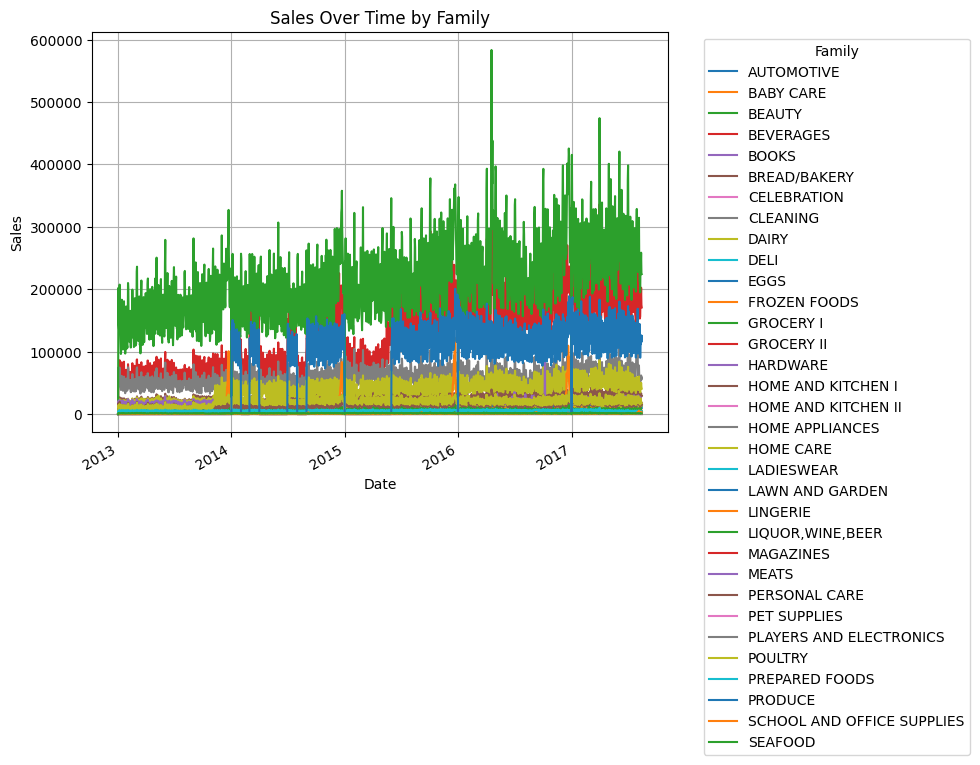

In [9]:
pivot_df = agg_df.pivot(index='date', columns='family', values='sales')

ax = pivot_df.plot(figsize=(10, 7))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time by Family')
plt.grid(True)
ax.legend(title='Family', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\Denis\AppData\Local\Temp\ipykernel_363812\1759841149.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(pivot_df.columns))


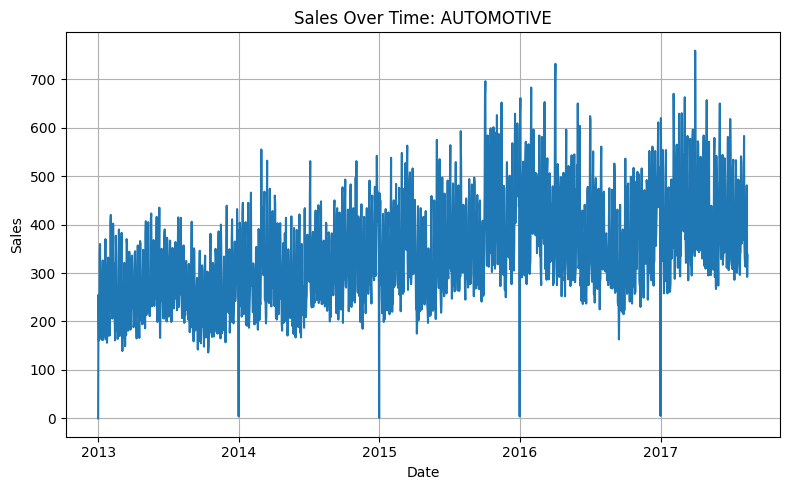

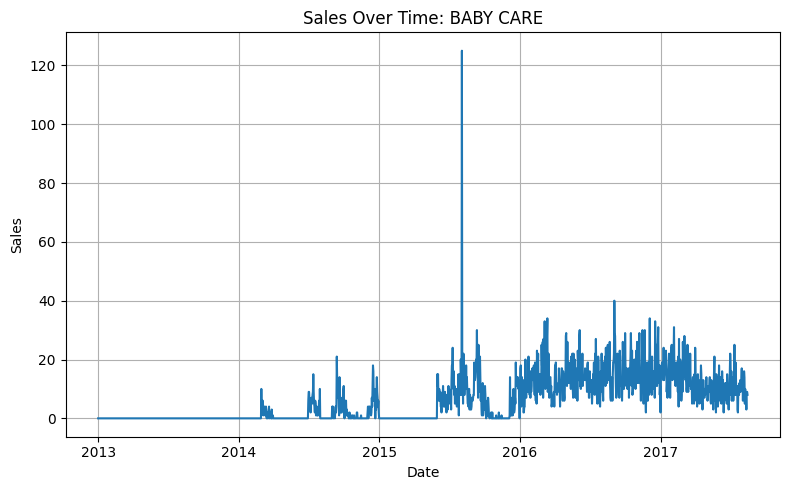

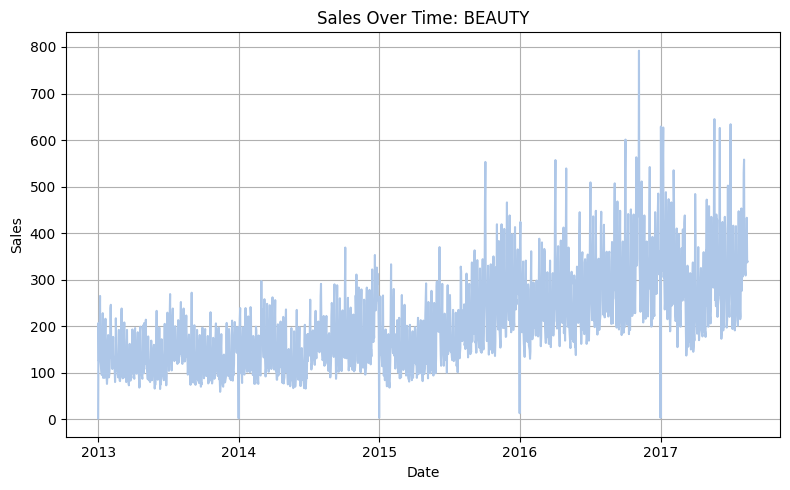

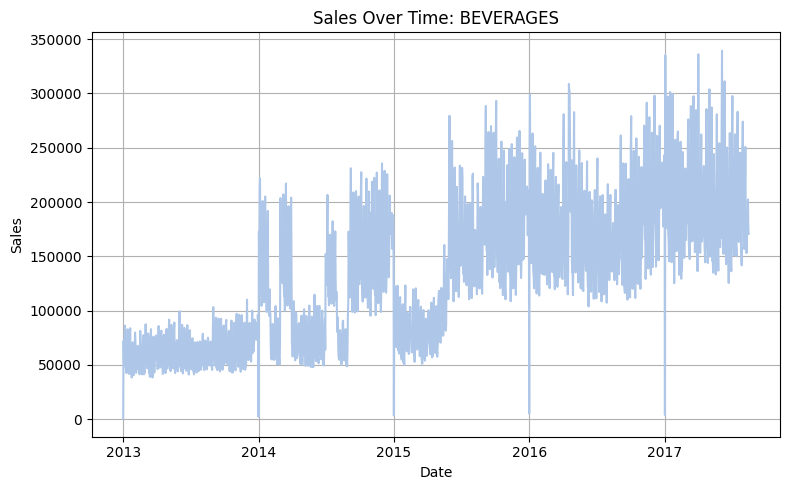

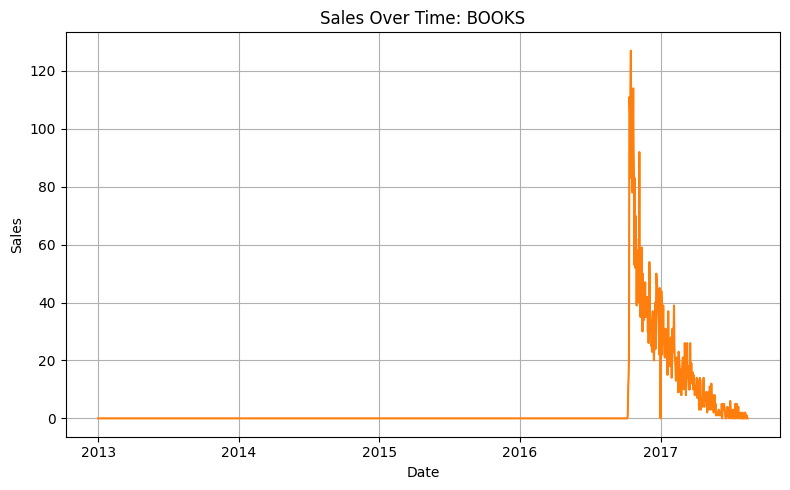

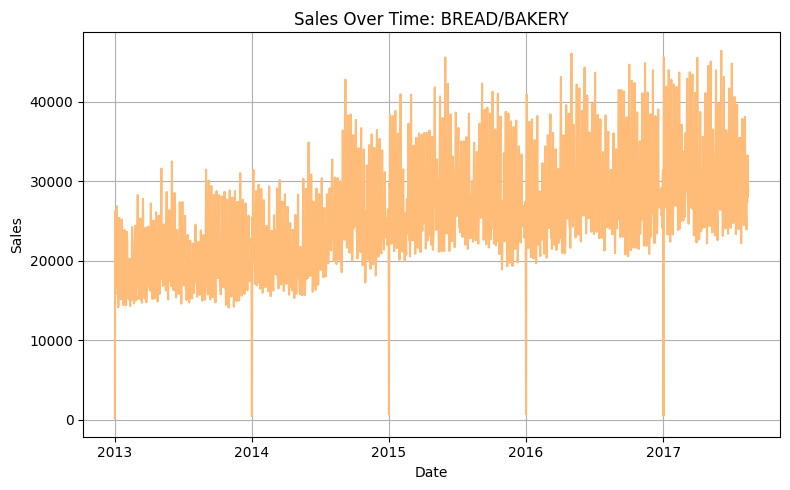

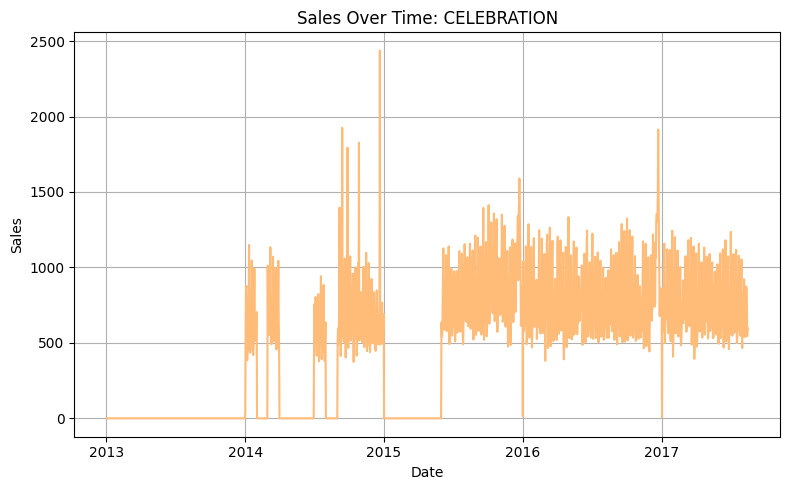

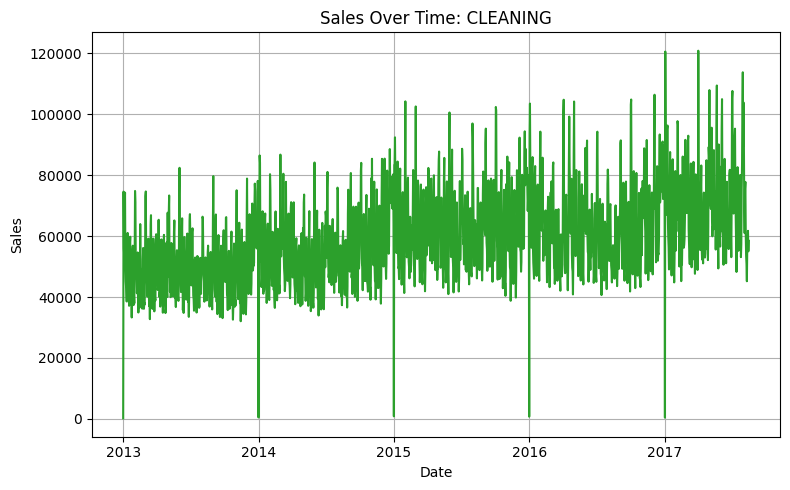

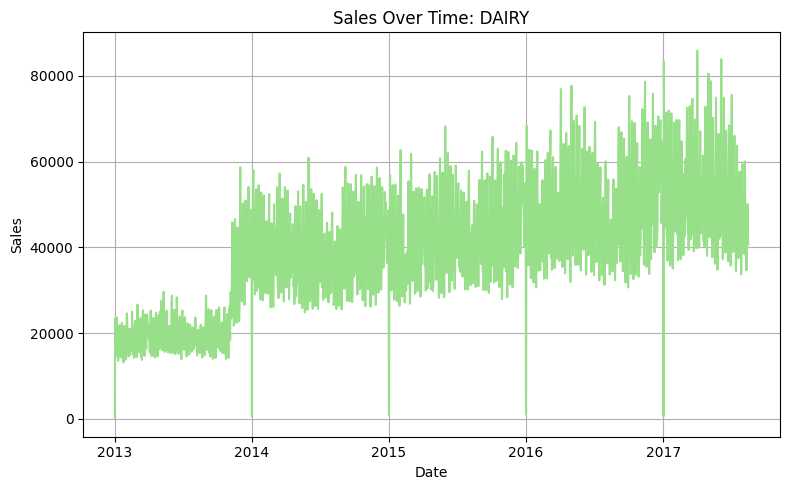

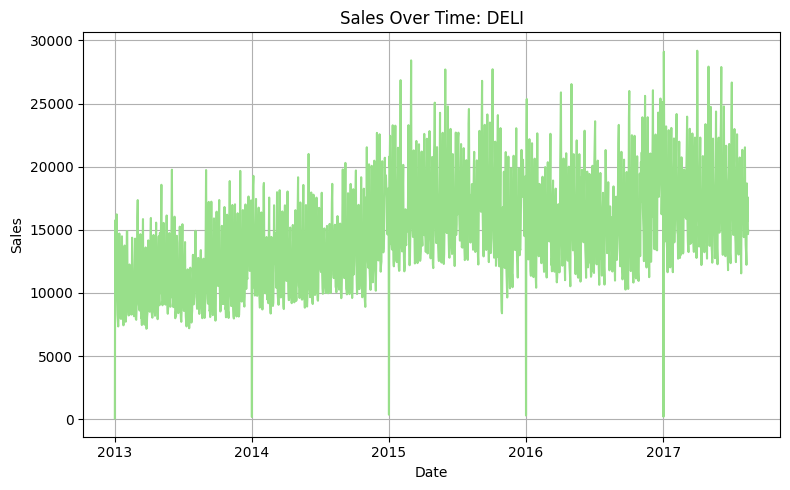

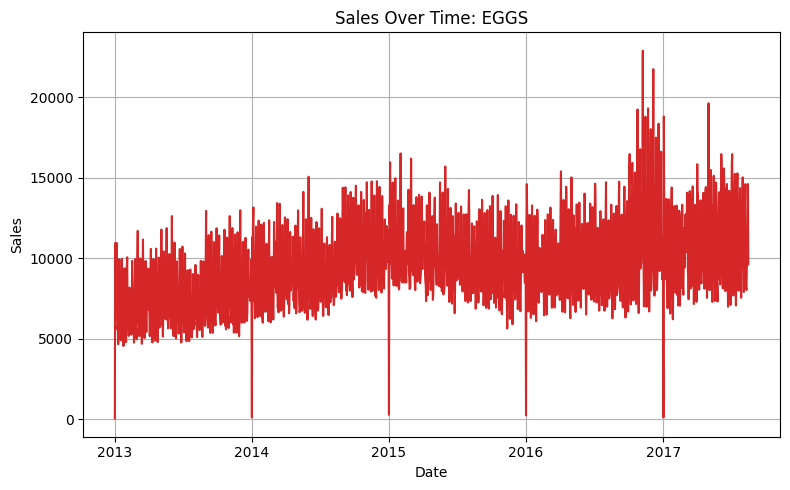

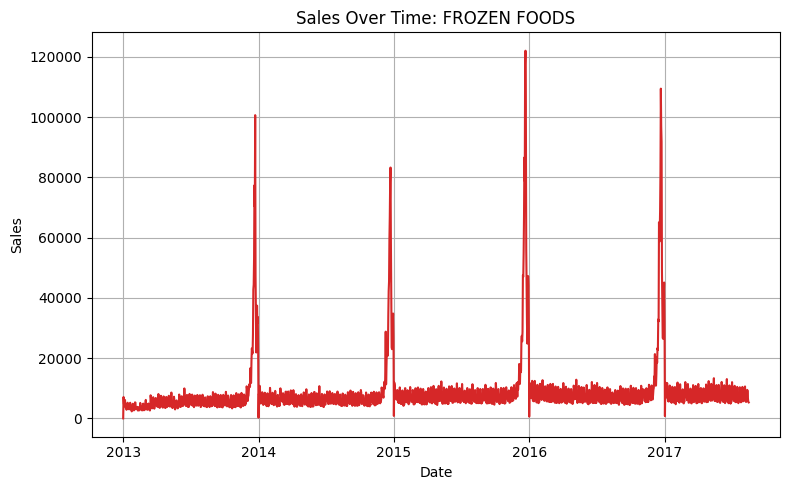

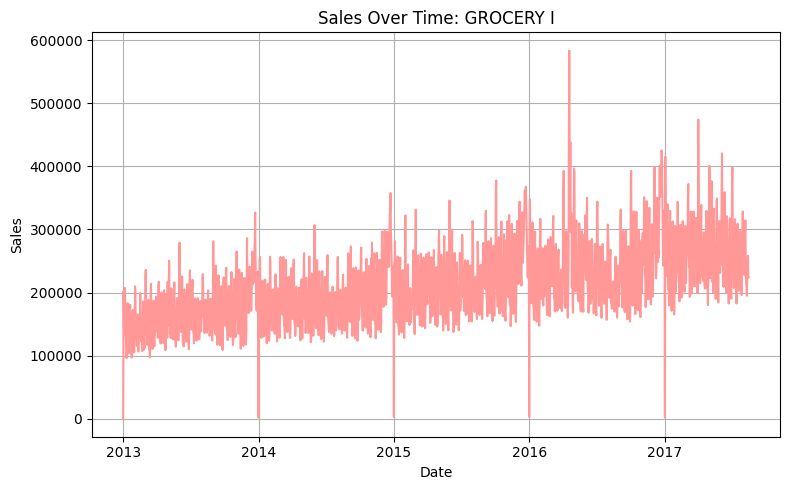

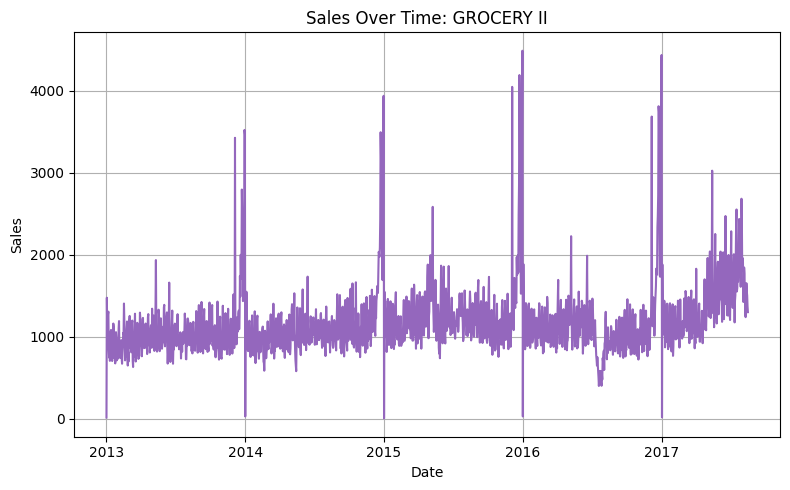

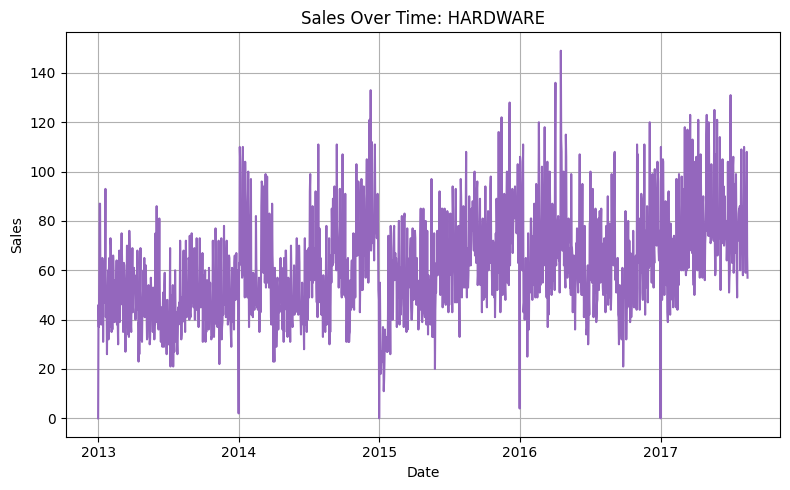

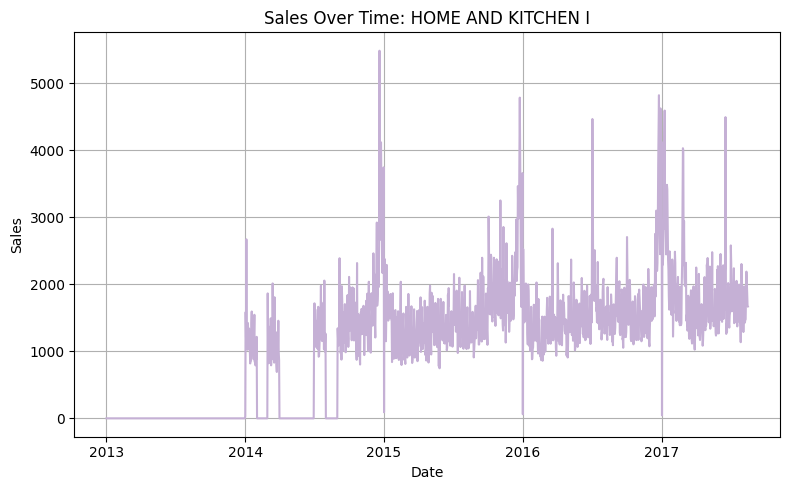

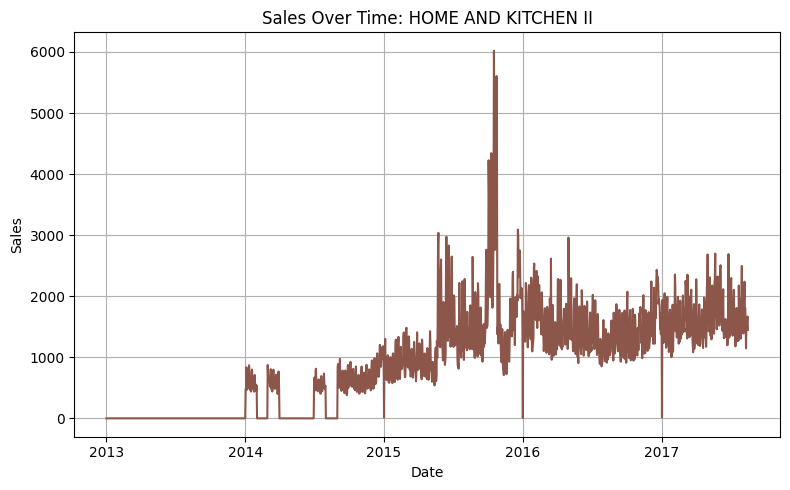

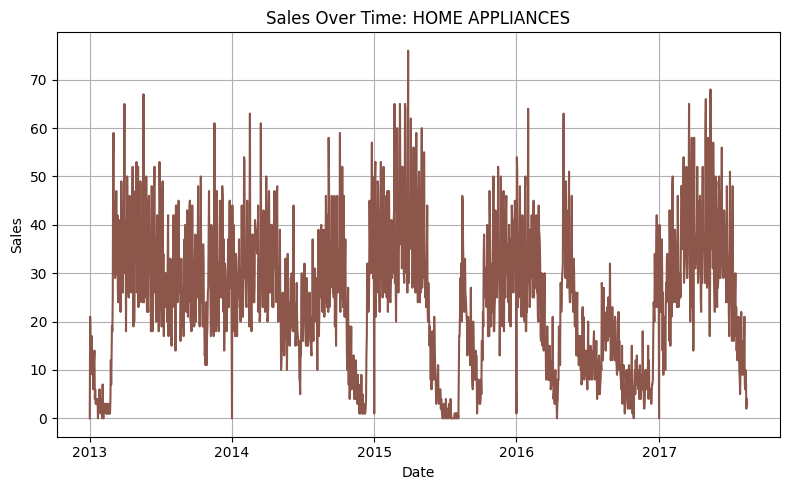

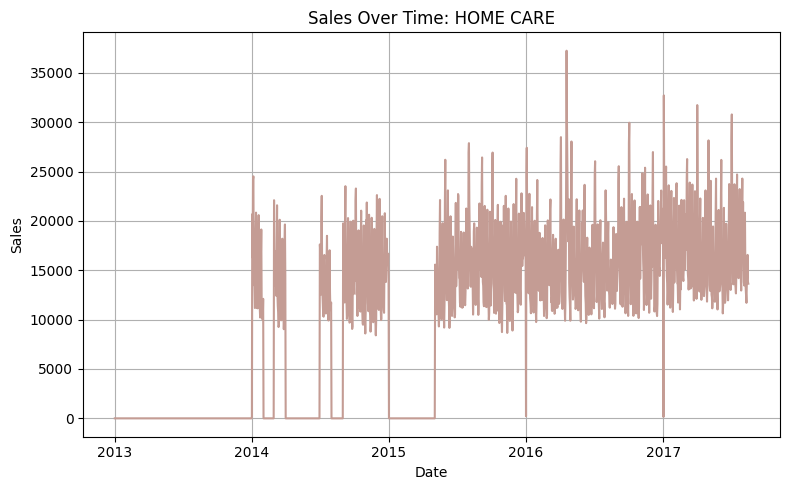

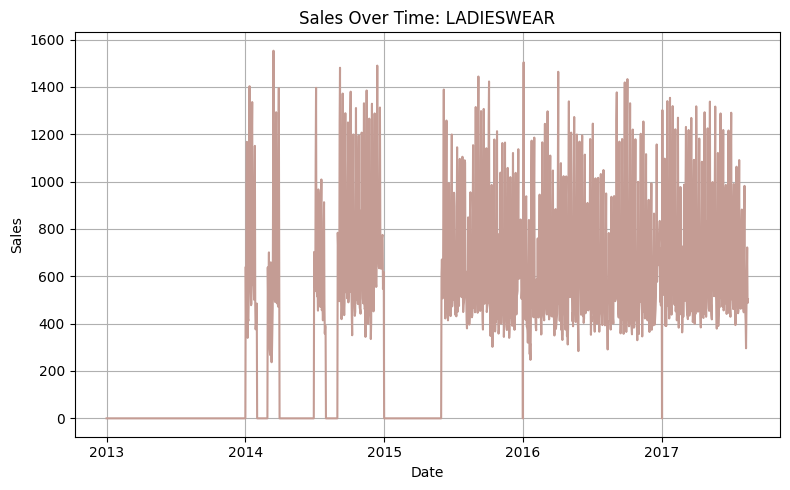

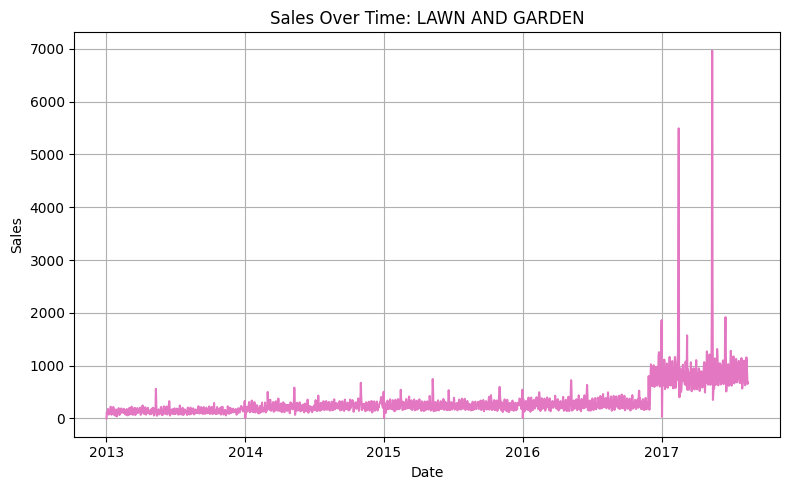

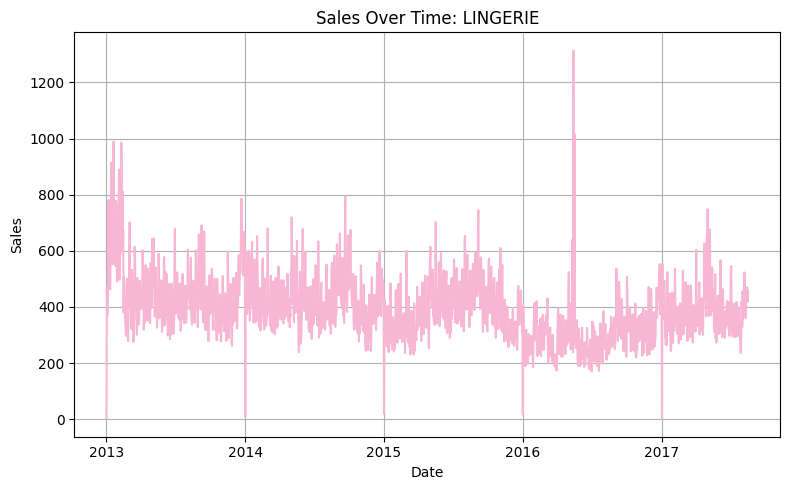

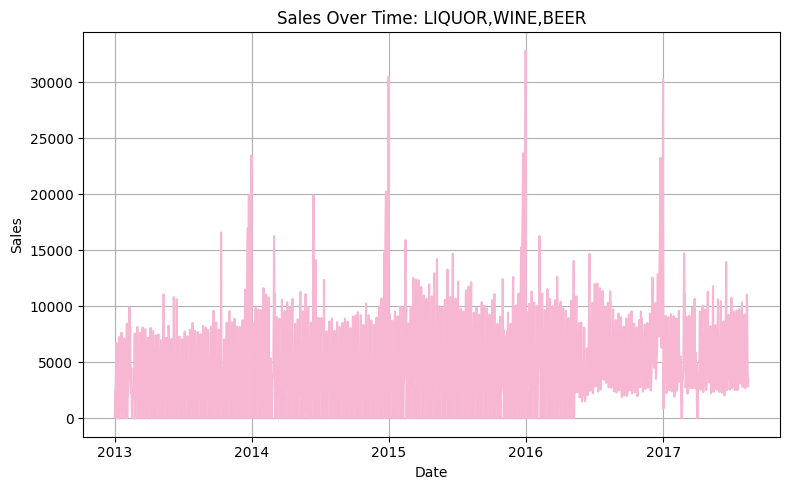

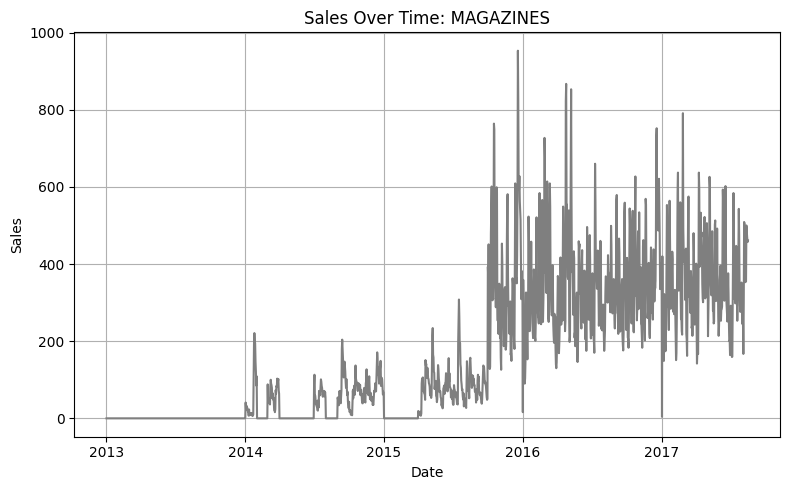

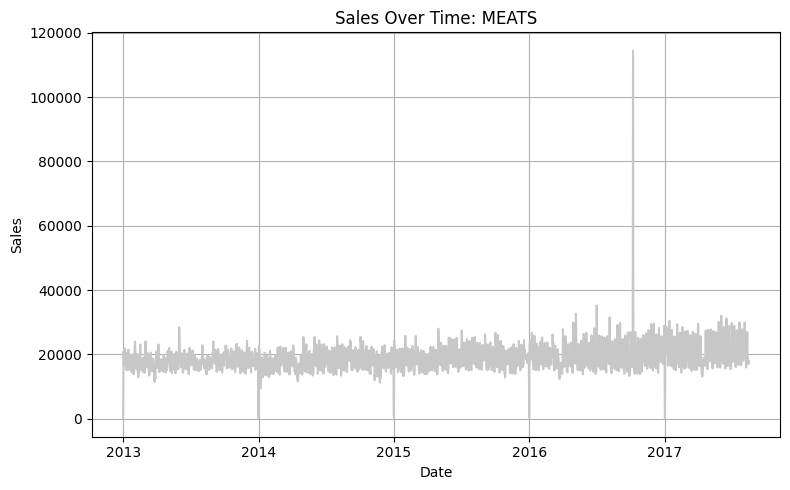

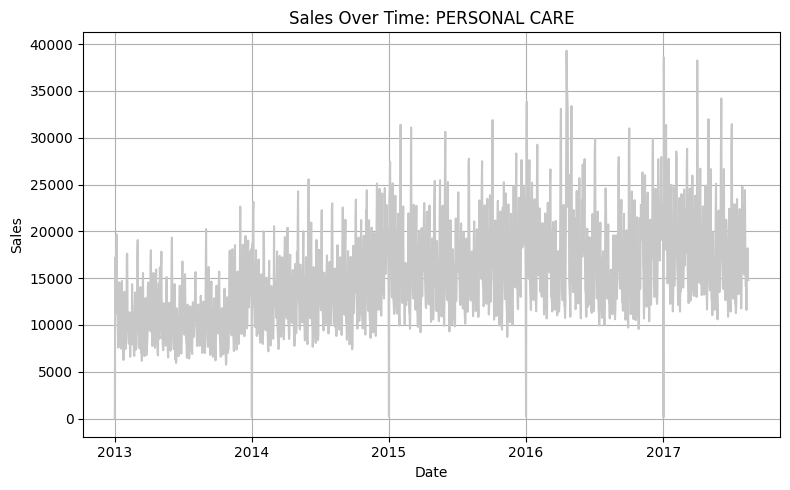

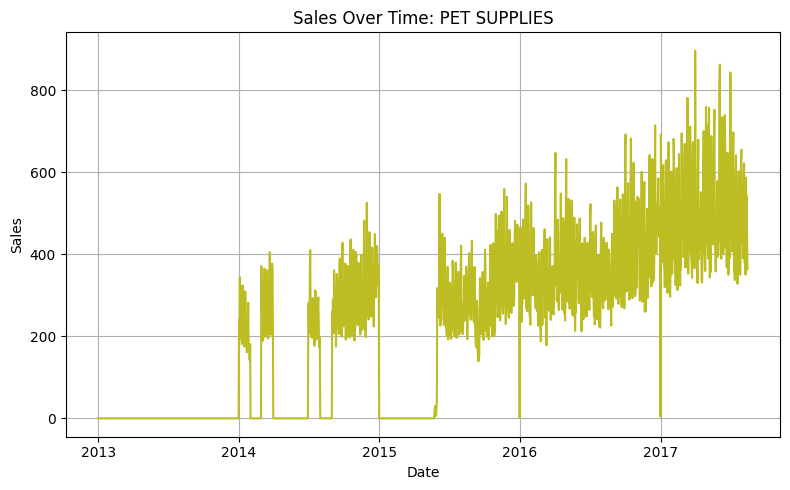

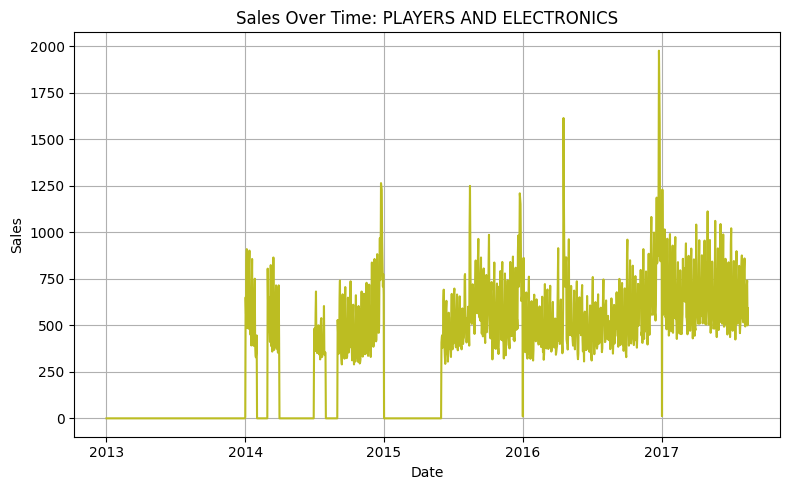

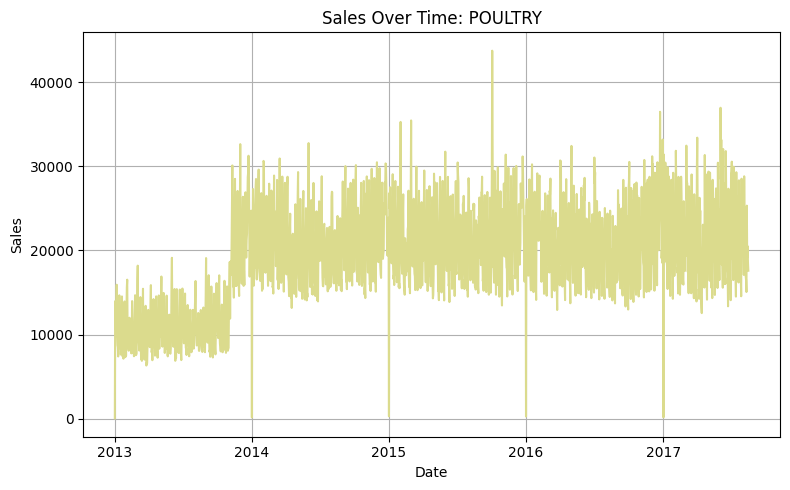

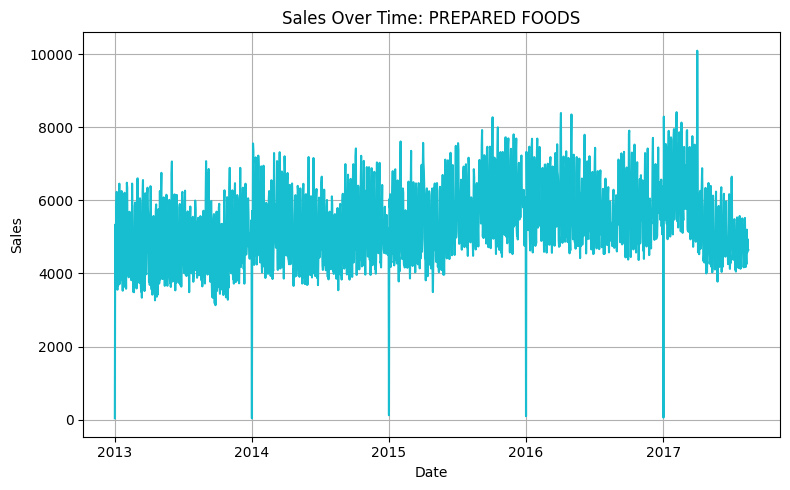

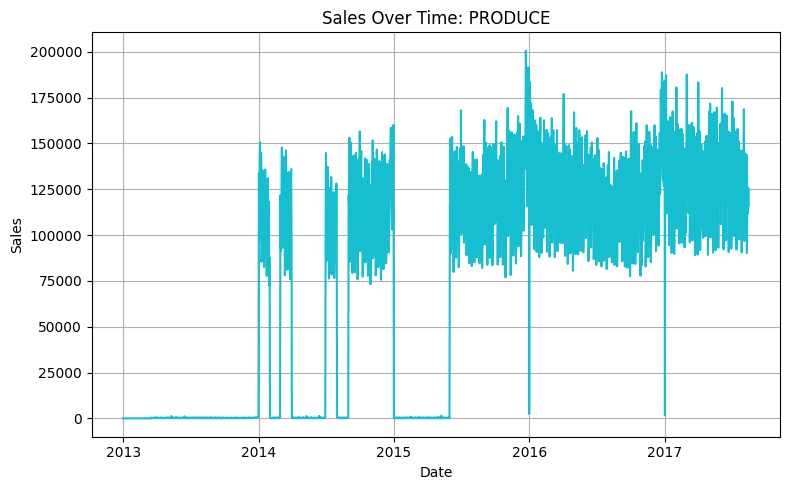

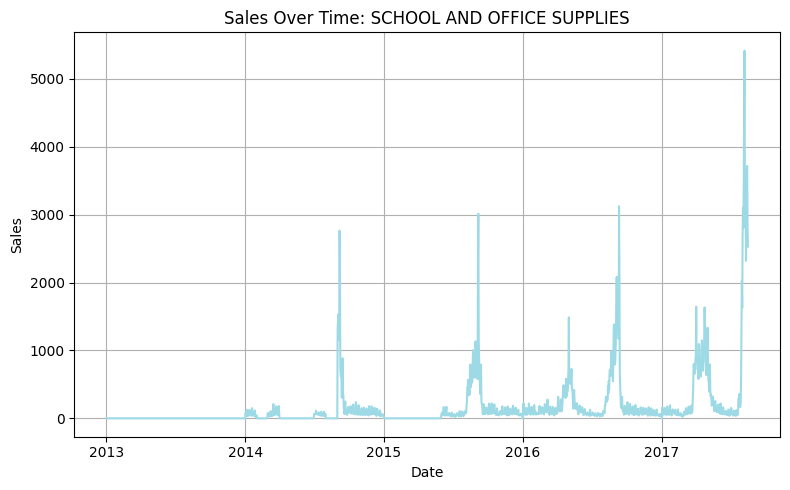

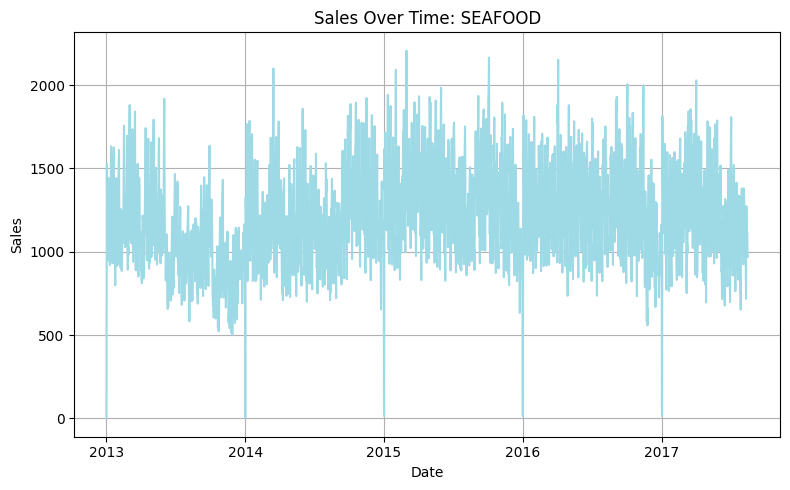

In [10]:
#Separate plots by category (family)
cmap = cm.get_cmap('tab20', len(pivot_df.columns))

for i, column in enumerate(pivot_df.columns):
    plt.figure(figsize=(8, 5))
    plt.plot(pivot_df.index, pivot_df[column], color=cmap(i))
    plt.title(f"Sales Over Time: {column}")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Data from June 2015 and before tends to either be missing or insufficient

In [11]:
min(agg_df['date']), max(agg_df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

We'll stick to the below periods for consistency

Test period will be **2017-06-15** to **2017-08-15**

Training period will be **2015-06-15** to **2017-06-14**

In [12]:
df2 = df[df.index>='2015-06-15']

In [13]:
grouped = df2.groupby(['date', 'family'])[['sales', 'onpromotion']].sum().reset_index().sort_values(['family','date'])

Let's stick to a few categories that have a good amount of sales first.

In [14]:
selected_families = [
    'PRODUCE','POULTRY'
]

In [15]:
filtered = grouped[grouped['family'].isin(selected_families)]
family_dfs = {
    family: df.reset_index(drop=True) 
    for family, df in filtered.groupby('family')
}

In [16]:
for family in family_dfs:
    family_dfs[family]['date'] = pd.to_datetime(family_dfs[family]['date'])
    family_dfs[family] = family_dfs[family].sort_values('date').set_index('date')

In [17]:
produce_df = family_dfs['PRODUCE']
poultry_df = family_dfs['POULTRY']

In [18]:
### ADF Test to check for Stationarity

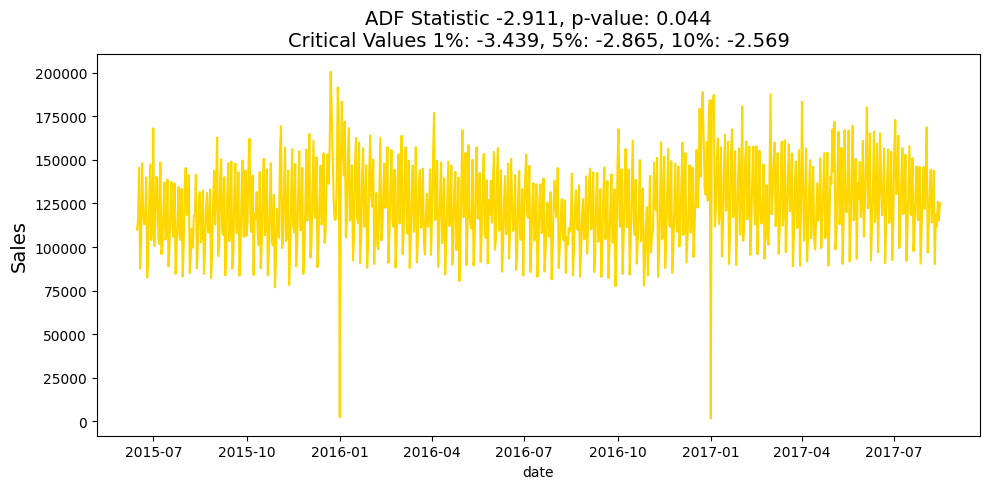

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
visualize_adfuller_results(produce_df['sales'], 'Sales', ax=ax)
plt.tight_layout()
plt.show()

Data stationarity is acceptable.

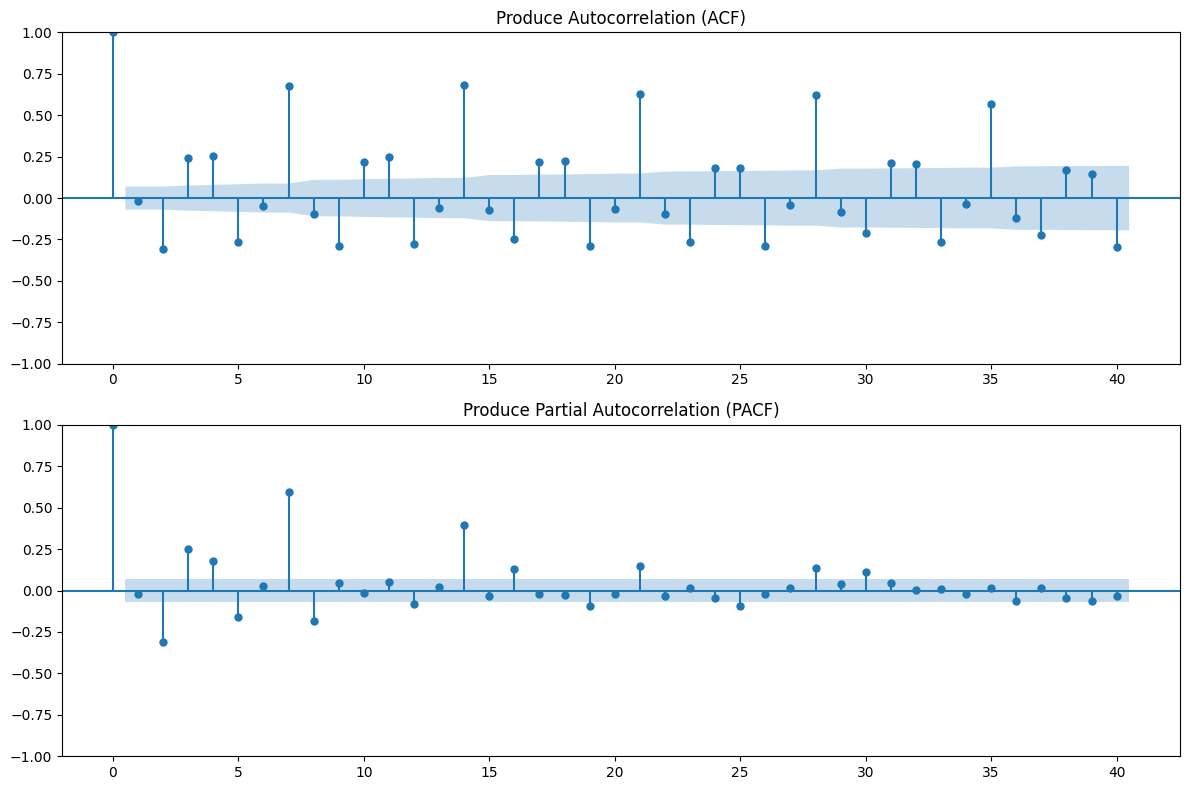

In [20]:
sales_series = produce_df['sales']

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(sales_series, ax=ax[0], lags=40)
plot_pacf(sales_series, ax=ax[1], lags=40, method='ywm')  # use 'ywm' for stable results

ax[0].set_title('Produce Autocorrelation (ACF)')
ax[1].set_title('Produce Partial Autocorrelation (PACF)')
plt.tight_layout()
plt.show()

Strong dayofweek / weekly seasonal pattern. Will differentiate it below

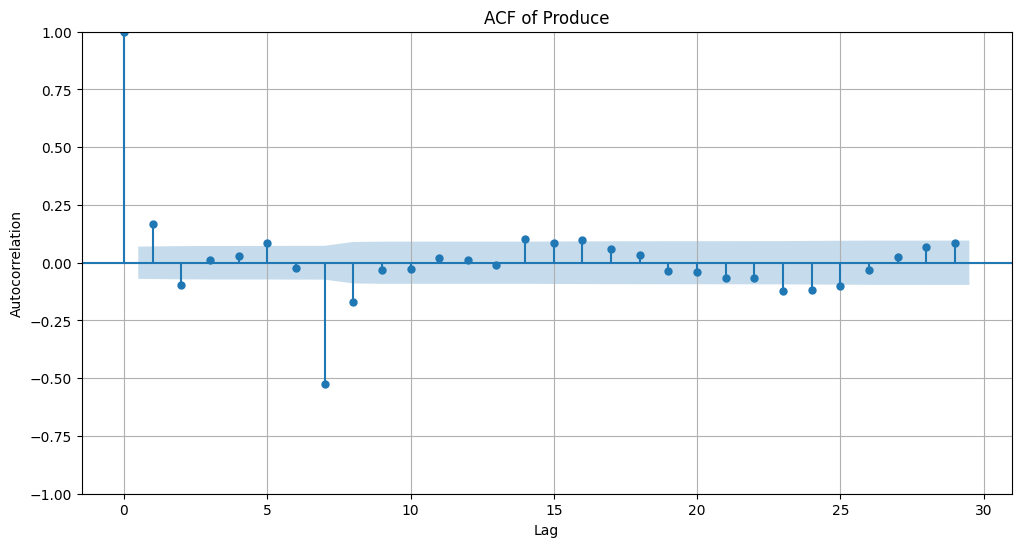

In [21]:
plot_seasonal_differenced_acf(produce_df['sales'],None,7,"ACF of Produce")

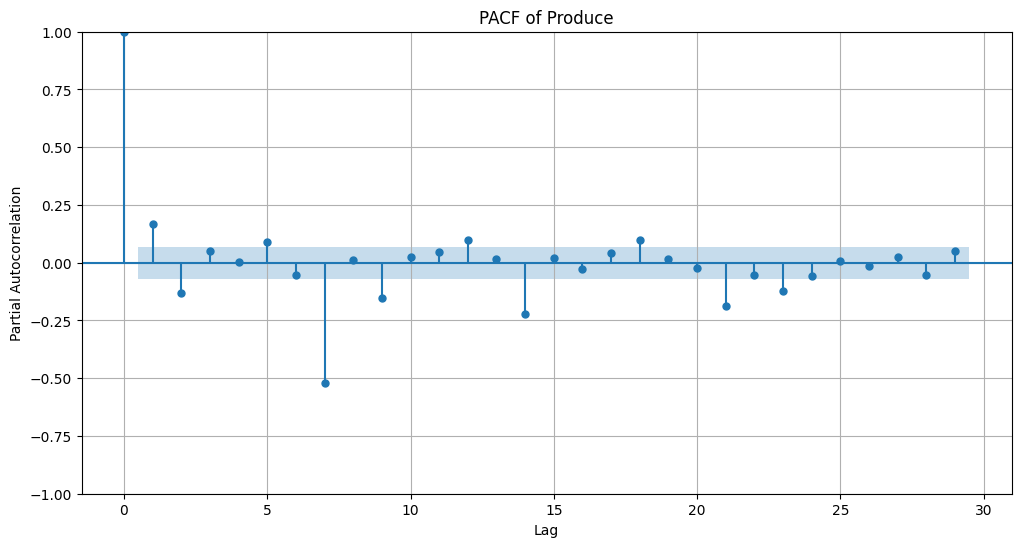

In [22]:
plot_seasonal_differenced_pacf(produce_df['sales'],None,7,"PACF of Produce")

We notice dropoffs past lag 2 for both ACF and PACF graphs. We'll test a range of 0:2 for p,q arima values.

In [23]:
##Timesplit
tss = TimeSeriesSplit(n_splits = 3, test_size = 60, gap = 0)
rmse_scores=[]
mape_scores =[]
best_rmse = float('inf')
best_forecast = None
best_test_actual = None
best_test_index = None

In [24]:
produce_df = produce_df.asfreq('D') 
produce_df = produce_df.fillna(method='ffill')

C:\Users\Denis\AppData\Local\Temp\ipykernel_363812\2584258541.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  produce_df = produce_df.fillna(method='ffill')


In [25]:
# Grid Search
p = d = q = range(0, 3)
param_grid = list(product(p, d, q))

# Fixed seasonal order
seasonal_order = (1, 1, 1, 7)

# Store results
results_summary = []

# Grid Search
for (p, d, q) in param_grid:
    rmse_scores = []
    mape_scores = []

    for fold, (train_index, test_index) in enumerate(tss.split(produce_df)):
        train_df = produce_df.iloc[train_index]
        test_df = produce_df.iloc[test_index]

        try:
            model = SARIMAX(
                endog=train_df['sales'],
                order=(p, d, q),
                seasonal_order=seasonal_order,
                enforce_stationarity=True,
                enforce_invertibility=True
            )
            results = model.fit(disp=False)

            forecast = results.forecast(steps=len(test_df))

            rmse = np.sqrt(mean_squared_error(test_df['sales'], forecast))
            mape_value = mape(test_df['sales'], forecast)

            rmse_scores.append(rmse)
            mape_scores.append(mape_value)

        except Exception as e:
            print(f"Failed: ARIMA({p},{d},{q}) -> {e}")
            break  # stop evaluating this parameter set if it fails

    if len(rmse_scores) == tss.get_n_splits():
        avg_rmse = np.mean(rmse_scores)
        avg_mape = np.mean(mape_scores)

        print(f"ARIMA({p},{d},{q}) -> AVG RMSE: {avg_rmse:.2f}, AVG MAPE: {avg_mape:.2f}%")

        results_summary.append({
            'order': (p, d, q),
            'avg_rmse': avg_rmse,
            'avg_mape': avg_mape
        })

ARIMA(0,0,0) -> AVG RMSE: 12152.88, AVG MAPE: 6.61%
ARIMA(0,0,1) -> AVG RMSE: 11875.59, AVG MAPE: 6.44%
ARIMA(0,0,2) -> AVG RMSE: 11808.15, AVG MAPE: 6.38%
ARIMA(0,1,0) -> AVG RMSE: 14705.06, AVG MAPE: 9.12%
ARIMA(0,1,1) -> AVG RMSE: 14846.85, AVG MAPE: 9.17%
ARIMA(0,1,2) -> AVG RMSE: 13824.12, AVG MAPE: 8.07%
ARIMA(0,2,0) -> AVG RMSE: 354013.32, AVG MAPE: 246.27%


C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0,2,1) -> AVG RMSE: 14509.07, AVG MAPE: 8.74%


C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0,2,2) -> AVG RMSE: 17525.92, AVG MAPE: 10.73%
ARIMA(1,0,0) -> AVG RMSE: 11728.67, AVG MAPE: 6.28%
ARIMA(1,0,1) -> AVG RMSE: 13162.68, AVG MAPE: 7.46%


C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1,0,2) -> AVG RMSE: 12999.25, AVG MAPE: 7.39%
ARIMA(1,1,0) -> AVG RMSE: 13832.07, AVG MAPE: 8.11%
ARIMA(1,1,1) -> AVG RMSE: 13823.15, AVG MAPE: 8.07%


C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1,1,2) -> AVG RMSE: 13863.26, AVG MAPE: 8.10%
ARIMA(1,2,0) -> AVG RMSE: 263233.61, AVG MAPE: 181.17%
ARIMA(1,2,1) -> AVG RMSE: 12217.68, AVG MAPE: 6.43%


C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1,2,2) -> AVG RMSE: 18591.07, AVG MAPE: 11.67%
ARIMA(2,0,0) -> AVG RMSE: 11689.75, AVG MAPE: 6.23%
ARIMA(2,0,1) -> AVG RMSE: 12991.49, AVG MAPE: 7.33%
ARIMA(2,0,2) -> AVG RMSE: 13004.01, AVG MAPE: 7.34%
ARIMA(2,1,0) -> AVG RMSE: 14283.33, AVG MAPE: 8.33%
ARIMA(2,1,1) -> AVG RMSE: 14002.18, AVG MAPE: 8.18%


C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2,1,2) -> AVG RMSE: 14048.83, AVG MAPE: 8.24%
ARIMA(2,2,0) -> AVG RMSE: 157376.24, AVG MAPE: 107.51%
ARIMA(2,2,1) -> AVG RMSE: 15839.74, AVG MAPE: 9.36%


C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2,2,2) -> AVG RMSE: 17655.69, AVG MAPE: 10.87%


In [26]:
# Sort and show best
results_summary.sort(key=lambda x: x['avg_rmse'])
best = results_summary[0]

print("\nBest model (based on average RMSE):")
print(f"Order: {best['order']}, AVG RMSE: {best['avg_rmse']:.2f}, AVG RMSE: {best['avg_mape']:.2f}%")



Best model (based on average RMSE):
Order: (2, 0, 0), AVG RMSE: 11689.75, AVG RMSE: 6.23%


In [27]:
seasonal_params = list(product(range(2), range(2), range(2)))
best_pdq = (2, 0, 0)

for P, D, Q in seasonal_params:
    try:
        model = SARIMAX(
            endog=train_df['sales'],
            order=best_pdq,
            seasonal_order=(P, D, Q, 7),
            enforce_stationarity=True,
            enforce_invertibility=True
        )
        results = model.fit(disp=False)
        forecast = results.forecast(steps=len(test_df))

        # Evaluate once
        rmse = np.sqrt(mean_squared_error(test_df['sales'], forecast))
        mape_val = mape(test_df['sales'], forecast)
        print(f"SARIMA{best_pdq}x({P},{D},{Q},7) -> RMSE: {rmse:.2f}, MAPE: {mape_val:.2f}%")

    except Exception as e:
        print(f"Failed: SARIMA{best_pdq}x({P},{D},{Q},7) -> {e}")


SARIMA(2, 0, 0)x(0,0,0,7) -> RMSE: 66202.46, MAPE: 46.32%
SARIMA(2, 0, 0)x(0,0,1,7) -> RMSE: 75551.02, MAPE: 52.92%
SARIMA(2, 0, 0)x(0,1,0,7) -> RMSE: 12079.59, MAPE: 7.06%
SARIMA(2, 0, 0)x(0,1,1,7) -> RMSE: 9524.00, MAPE: 5.54%
SARIMA(2, 0, 0)x(1,0,0,7) -> RMSE: 16667.56, MAPE: 10.72%
SARIMA(2, 0, 0)x(1,0,1,7) -> RMSE: 8977.79, MAPE: 5.04%
SARIMA(2, 0, 0)x(1,1,0,7) -> RMSE: 12733.11, MAPE: 6.97%
SARIMA(2, 0, 0)x(1,1,1,7) -> RMSE: 9471.17, MAPE: 5.50%


In [28]:
for fold, (train_index, test_index) in enumerate(tss.split(produce_df)):
    train_df = produce_df.iloc[train_index]
    test_df = produce_df.iloc[test_index]
    
    model = SARIMAX(
        endog=train_df['sales'],
        exog=None,
        order=(2, 0, 0),
        seasonal_order=(1, 0, 1, 7),
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    results = model.fit(disp=False)

    forecast = results.forecast(steps=len(test_df))

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(test_df['sales'], forecast))
    mape_value = mape(test_df['sales'], forecast)

    rmse_scores.append(rmse)
    mape_scores.append(mape_value)

    # Save best model
    if rmse < best_rmse:
        best_rmse = rmse
        best_mape = mape_value
        best_forecast = forecast
        best_test_actual = test_df['sales']
        best_test_index = test_df.index

    print(f"Fold {fold + 1}: RMSE = {rmse:.2f}, MAPE = {mape_value:.2f}%")

Fold 1: RMSE = 12739.12, MAPE = 7.09%
Fold 2: RMSE = 13334.24, MAPE = 6.22%
Fold 3: RMSE = 8977.79, MAPE = 5.04%


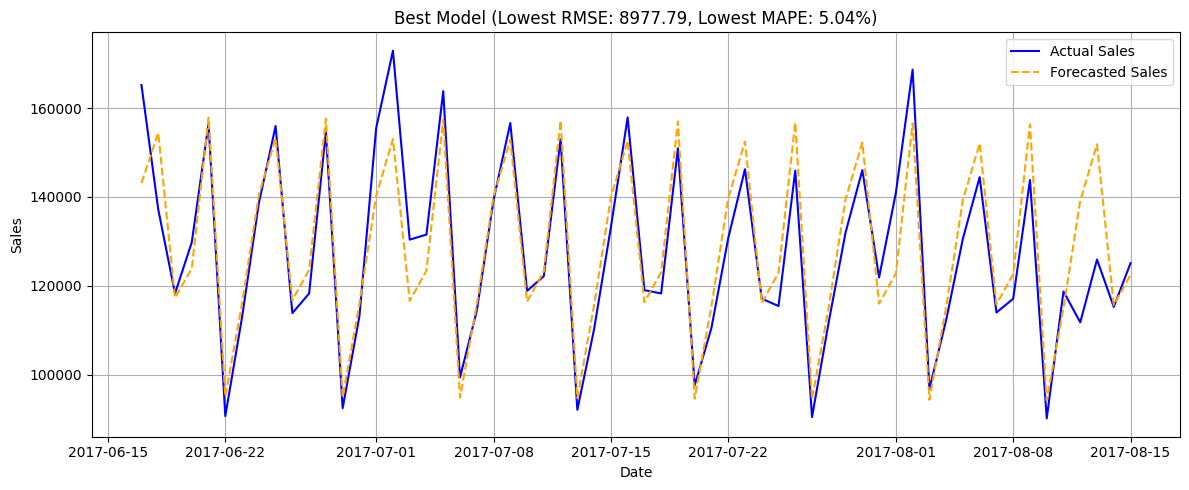

In [29]:
plt.figure(figsize=(12, 5))
plt.plot(best_test_index, best_test_actual, label='Actual Sales', color='blue')
plt.plot(best_test_index, best_forecast, label='Forecasted Sales', color='orange', linestyle='--')
plt.title(f'Best Model (Lowest RMSE: {best_rmse:.2f}, Lowest MAPE: {best_mape:.2f}%)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

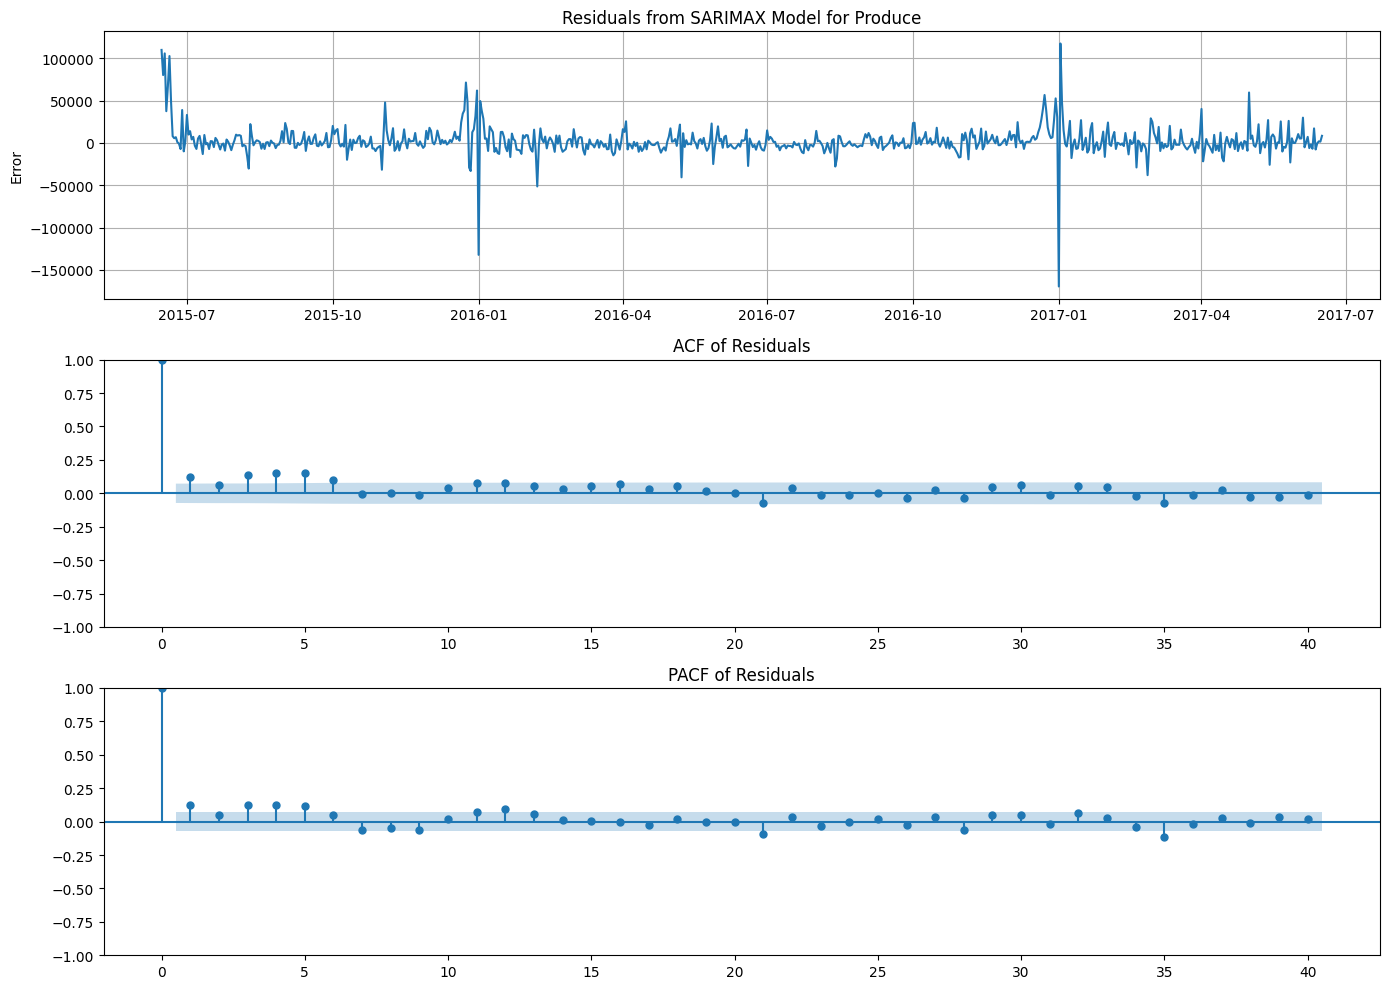

In [30]:
###Residual Visualisation
results = model.fit()

# Get residuals
residuals = results.resid

# Plot residuals
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 1. Raw residuals
axes[0].plot(residuals)
axes[0].set_title('Residuals from SARIMAX Model for Produce')
axes[0].set_ylabel('Error')
axes[0].grid(True)

# 2. ACF
plot_acf(residuals, lags=40, ax=axes[1])
axes[1].set_title('ACF of Residuals')

# 3. PACF
plot_pacf(residuals, lags=40, ax=axes[2])
axes[2].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()


Forecasting for produce

In [31]:
# Fit on entire historical data
final_model = SARIMAX(
    endog=produce_df['sales'],
    order=(2, 0, 0),                 
    seasonal_order=(1, 1, 1, 7),     
    enforce_stationarity=True,
    enforce_invertibility=True
)
final_results = final_model.fit(disp=False)

In [32]:
n_forecast_steps = 730  # 2 years

forecast = final_results.get_forecast(steps=n_forecast_steps)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()  # confidence intervals

In [33]:
last_date = produce_df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_forecast_steps, freq='D')
forecast_mean.index = forecast_index
conf_int.index = forecast_index


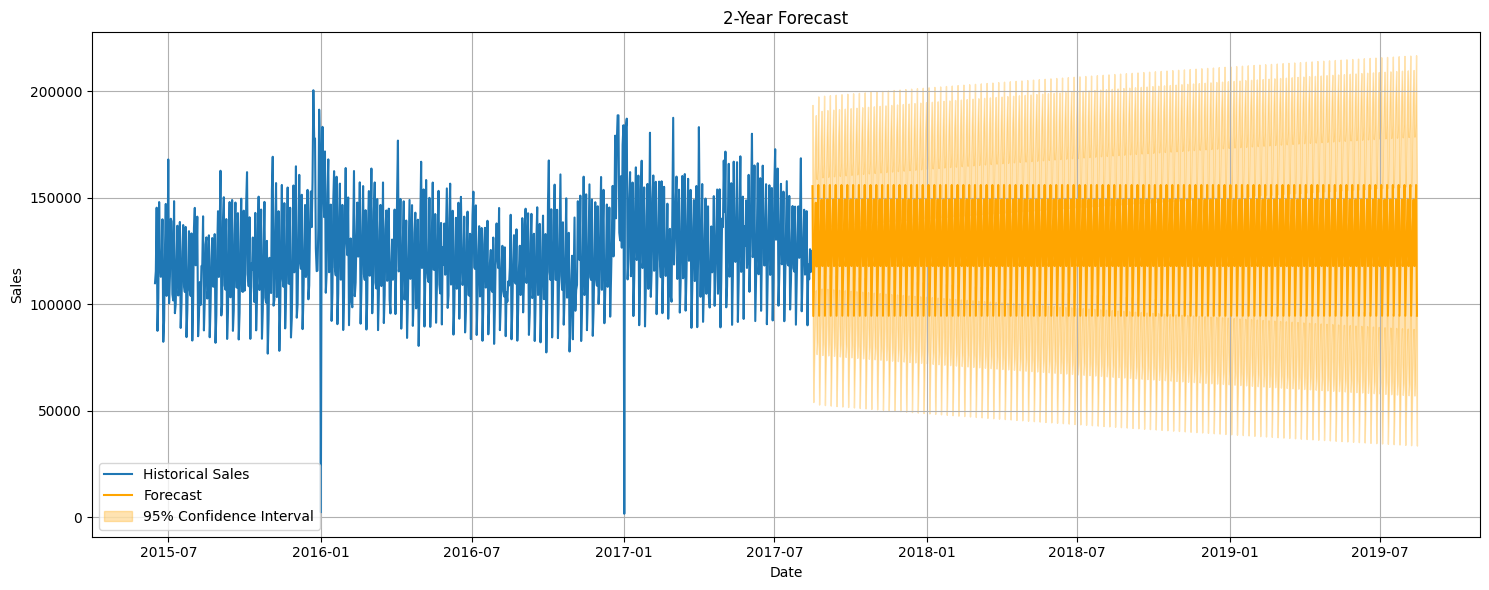

In [34]:
plt.figure(figsize=(15, 6))

# Plot past data
plt.plot(produce_df.index, produce_df['sales'], label='Historical Sales')

# Plot forecast
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='orange')

# Plot confidence intervals
plt.fill_between(forecast_index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='orange', alpha=0.3, label='95% Confidence Interval')

plt.title("2-Year Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


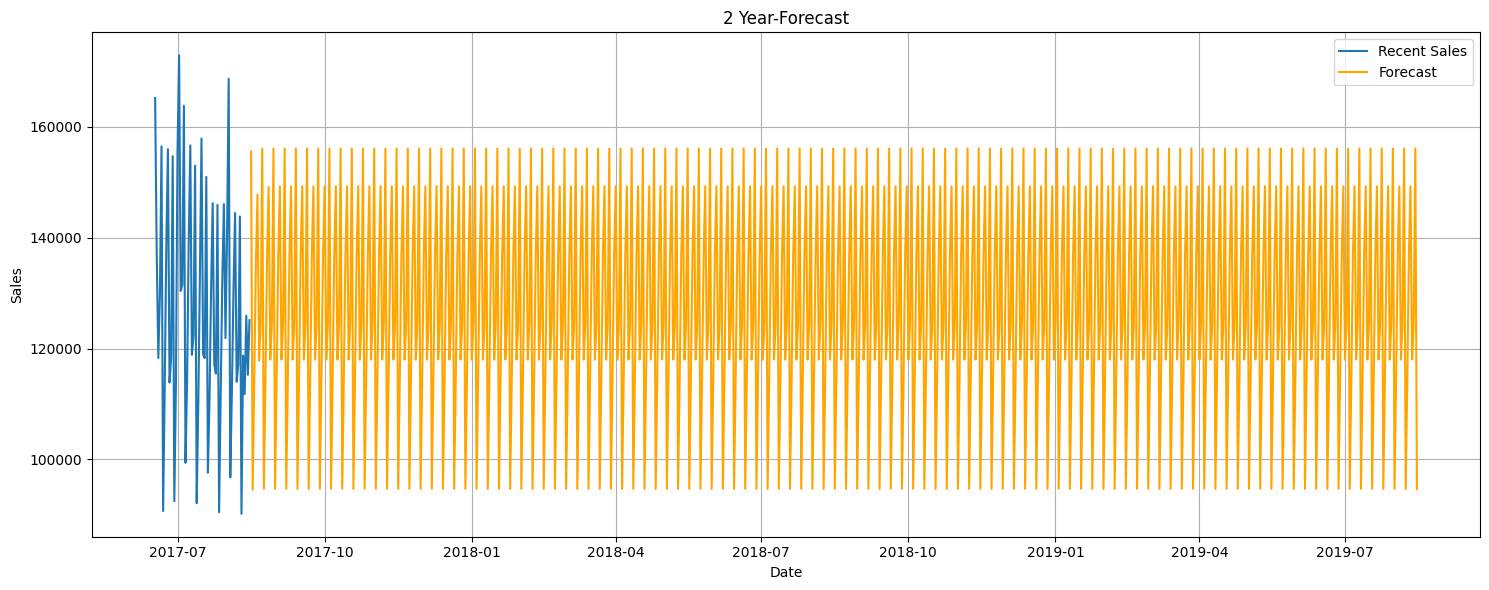

In [35]:
context_days = 60 

recent_history = produce_df.iloc[-context_days:]

plt.figure(figsize=(15, 6))

# Historical data (just last 60 days)
plt.plot(recent_history.index, recent_history['sales'], label='Recent Sales')

# Forecast
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='orange')

plt.title("2 Year-Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Poultry

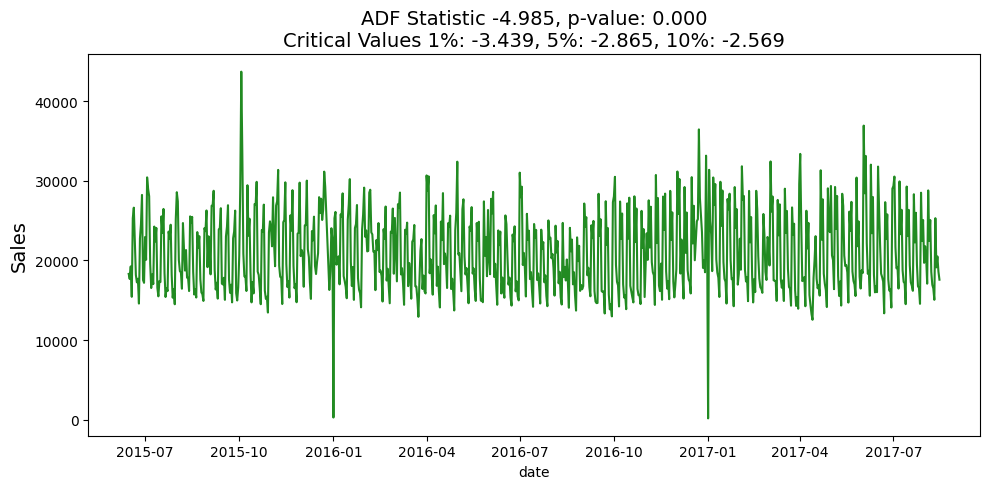

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
visualize_adfuller_results(poultry_df['sales'], 'Sales', ax=ax)
plt.tight_layout()
plt.show()

Data is stationary

In [37]:
poultry_df = poultry_df.asfreq('D') 
poultry_df = poultry_df.fillna(method='ffill')

C:\Users\Denis\AppData\Local\Temp\ipykernel_363812\2860136199.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  poultry_df = poultry_df.fillna(method='ffill')


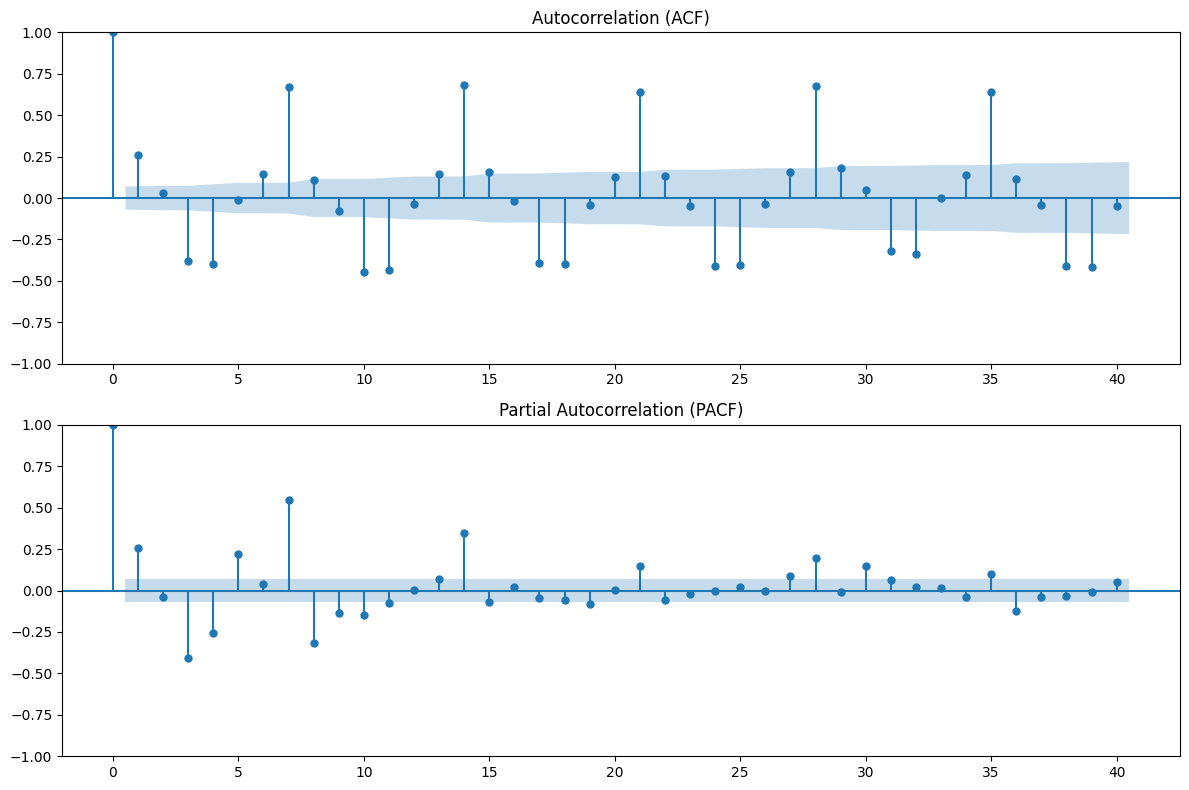

In [38]:
sales_series = poultry_df['sales']

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(sales_series, ax=ax[0], lags=40)
plot_pacf(sales_series, ax=ax[1], lags=40, method='ywm')  # use 'ywm' for stable results

ax[0].set_title('Autocorrelation (ACF)')
ax[1].set_title('Partial Autocorrelation (PACF)')
plt.tight_layout()
plt.show()

Strong dayofweek / weekly seasonal pattern. Will differentiate it below

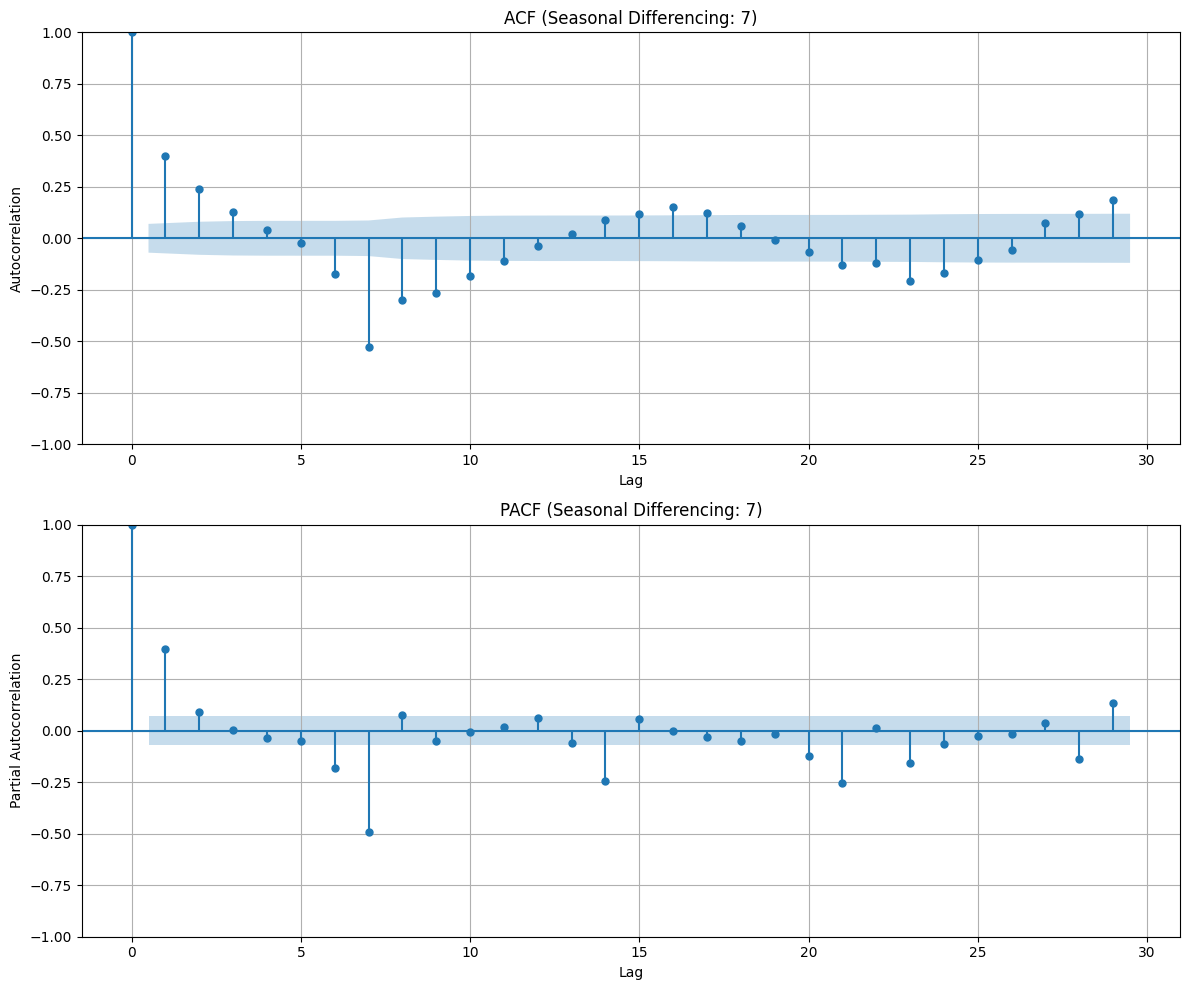

In [39]:
plot_seasonal_differenced_acf_pacf(poultry_df['sales'], seasonal_period=7)

We notice dropoffs past lag 3 for ACF graph and past lag 1 for PACF graph. We'll test a range of 0-3 for p, and 0-1 for q.

In [40]:
##Timesplit
tss = TimeSeriesSplit(n_splits = 3, test_size = 60, gap = 0)
rmse_scores=[]
mape_scores =[]
best_rmse = float('inf')
best_forecast = None
best_test_actual = None
best_test_index = None

In [41]:
poultry_df = poultry_df.asfreq('D') 
poultry_df = poultry_df.fillna(method='ffill')

C:\Users\Denis\AppData\Local\Temp\ipykernel_363812\2860136199.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  poultry_df = poultry_df.fillna(method='ffill')


In [42]:
# Grid Search
p = range(0,4)
d = range(0,1)
q = range(0,2)
param_grid = list(product(p, d, q))

# Fixed seasonal order
seasonal_order = (1, 1, 1, 7)

# Store results
results_summary = []

# Grid Search
for (p, d, q) in param_grid:
    rmse_scores = []
    mape_scores = []

    for fold, (train_index, test_index) in enumerate(tss.split(poultry_df)):
        train_df = poultry_df.iloc[train_index]
        test_df = poultry_df.iloc[test_index]

        try:
            model = SARIMAX(
                endog=train_df['sales'],
                order=(p, d, q),
                seasonal_order=seasonal_order,
                enforce_stationarity=True,
                enforce_invertibility=True
            )
            results = model.fit(disp=False)

            forecast = results.forecast(steps=len(test_df))

            rmse = np.sqrt(mean_squared_error(test_df['sales'], forecast))
            mape_value = mape(test_df['sales'], forecast)

            rmse_scores.append(rmse)
            mape_scores.append(mape_value)

        except Exception as e:
            print(f"Failed: ARIMA({p},{d},{q}) -> {e}")
            break  # stop evaluating this parameter set if it fails

    if len(rmse_scores) == tss.get_n_splits():
        avg_rmse = np.mean(rmse_scores)
        avg_mape = np.mean(mape_scores)

        print(f"ARIMA({p},{d},{q}) -> AVG RMSE: {avg_rmse:.2f}, AVG MAPE: {avg_mape:.2f}%")

        results_summary.append({
            'order': (p, d, q),
            'avg_rmse': avg_rmse,
            'avg_mape': avg_mape
        })

ARIMA(0,0,0) -> AVG RMSE: 2804.04, AVG MAPE: 9.55%
ARIMA(0,0,1) -> AVG RMSE: 2743.81, AVG MAPE: 9.33%
ARIMA(1,0,0) -> AVG RMSE: 2719.27, AVG MAPE: 9.24%
ARIMA(1,0,1) -> AVG RMSE: 2710.83, AVG MAPE: 9.18%
ARIMA(2,0,0) -> AVG RMSE: 2713.48, AVG MAPE: 9.20%


C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed: ARIMA(2,0,1) -> LU decomposition error.
ARIMA(3,0,0) -> AVG RMSE: 2719.21, AVG MAPE: 9.24%


C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3,0,1) -> AVG RMSE: 3087.60, AVG MAPE: 11.20%


C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [43]:
# Sort and show best
results_summary.sort(key=lambda x: x['avg_rmse'])
best = results_summary[0]

print("\nBest model (based on average RMSE):")
print(f"Order: {best['order']}, AVG RMSE: {best['avg_rmse']:.2f}, AVG RMSE: {best['avg_mape']:.2f}%")



Best model (based on average RMSE):
Order: (1, 0, 1), AVG RMSE: 2710.83, AVG RMSE: 9.18%


In [44]:
seasonal_params = list(product(range(2), range(2), range(2)))
best_pdq = (1, 0, 1)

for P, D, Q in seasonal_params:
    try:
        model = SARIMAX(
            endog=train_df['sales'],
            order=best_pdq,
            seasonal_order=(P, D, Q, 7),
            enforce_stationarity=True,
            enforce_invertibility=True
        )
        results = model.fit(disp=False)
        forecast = results.forecast(steps=len(test_df))

        # Evaluate once
        rmse = np.sqrt(mean_squared_error(test_df['sales'], forecast))
        mape_val = mape(test_df['sales'], forecast)
        print(f"SARIMA{best_pdq}x({P},{D},{Q},7) -> RMSE: {rmse:.2f}, MAPE: {mape_val:.2f}%")

    except Exception as e:
        print(f"Failed: SARIMA{best_pdq}x({P},{D},{Q},7) -> {e}")

SARIMA(1, 0, 1)x(0,0,0,7) -> RMSE: 4748.28, MAPE: 20.69%
SARIMA(1, 0, 1)x(0,0,1,7) -> RMSE: 4612.12, MAPE: 19.28%
SARIMA(1, 0, 1)x(0,1,0,7) -> RMSE: 2632.67, MAPE: 9.06%
SARIMA(1, 0, 1)x(0,1,1,7) -> RMSE: 2038.78, MAPE: 7.13%


C:\Users\Denis\anaconda3\envs\first\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 1)x(1,0,0,7) -> RMSE: 6275.06, MAPE: 27.39%
SARIMA(1, 0, 1)x(1,0,1,7) -> RMSE: 2067.41, MAPE: 7.66%
SARIMA(1, 0, 1)x(1,1,0,7) -> RMSE: 2783.82, MAPE: 9.39%
SARIMA(1, 0, 1)x(1,1,1,7) -> RMSE: 2012.43, MAPE: 7.03%


In [45]:
for fold, (train_index, test_index) in enumerate(tss.split(poultry_df)):
    train_df = poultry_df.iloc[train_index]
    test_df = poultry_df.iloc[test_index]
    
    model = SARIMAX(
        endog=train_df['sales'],
        exog=None,
        order=(1, 0, 1),
        seasonal_order=(1, 1, 1, 7),
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    results = model.fit(disp=False)

    forecast = results.forecast(steps=len(test_df))

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(test_df['sales'], forecast))
    mape_value = mape(test_df['sales'], forecast)

    rmse_scores.append(rmse)
    mape_scores.append(mape_value)

    # Save best model
    if rmse < best_rmse:
        best_rmse = rmse
        best_forecast = forecast
        best_mape = mape_value
        best_test_actual = test_df['sales']
        best_test_index = test_df.index

    print(f"Fold {fold + 1}: RMSE = {rmse:.2f}, MAPE = {mape_value:.2f}%")

Fold 1: RMSE = 3172.55, MAPE = 12.69%
Fold 2: RMSE = 2947.51, MAPE = 7.82%
Fold 3: RMSE = 2012.43, MAPE = 7.03%


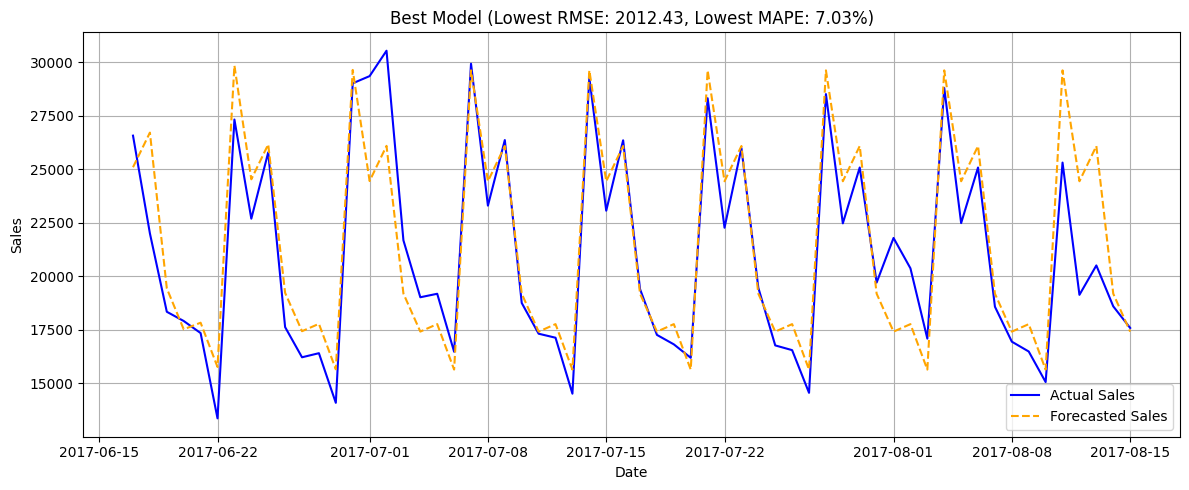

In [46]:
plt.figure(figsize=(12, 5))
plt.plot(best_test_index, best_test_actual, label='Actual Sales', color='blue')
plt.plot(best_test_index, best_forecast, label='Forecasted Sales', color='orange', linestyle='--')
plt.title(f'Best Model (Lowest RMSE: {best_rmse:.2f}, Lowest MAPE: {best_mape:.2f}%)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

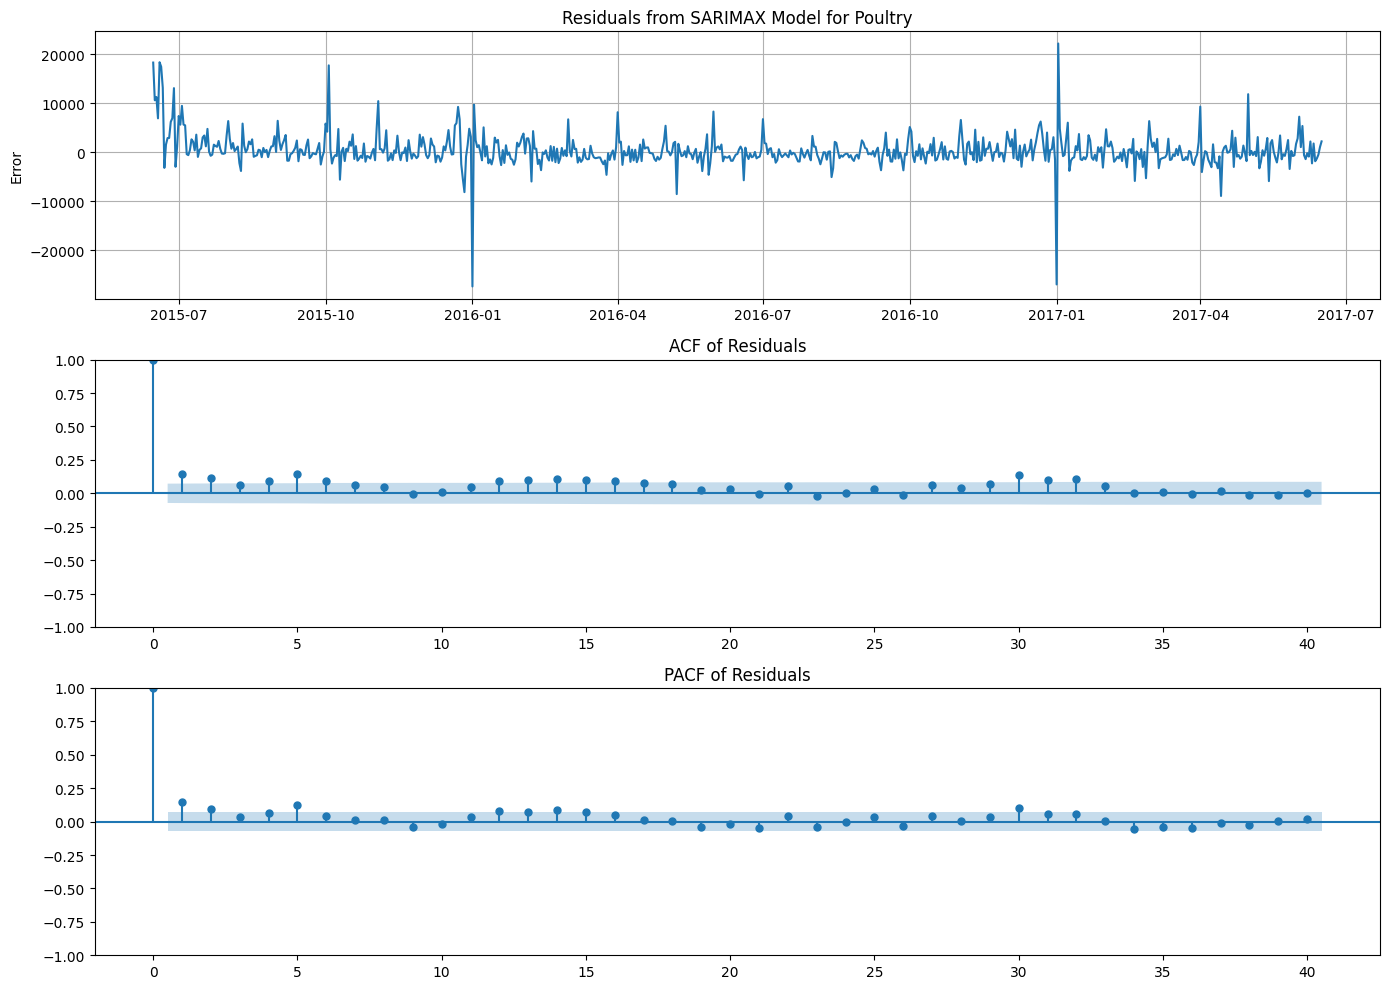

In [47]:
###Residual Visualisation
results = model.fit()

# Get residuals
residuals = results.resid

# Plot residuals
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Raw residuals
axes[0].plot(residuals)
axes[0].set_title('Residuals from SARIMAX Model for Poultry')
axes[0].set_ylabel('Error')
axes[0].grid(True)

# ACF
plot_acf(residuals, lags=40, ax=axes[1])
axes[1].set_title('ACF of Residuals')

# PACF
plot_pacf(residuals, lags=40, ax=axes[2])
axes[2].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()


In [48]:
# Fit on entire historical data
final_model = SARIMAX(
    endog=poultry_df['sales'],
    order=(1, 0, 1),                 
    seasonal_order=(1, 1, 1, 7), 
    enforce_stationarity=True,
    enforce_invertibility=True
)
final_results = final_model.fit(disp=False)

In [49]:
n_forecast_steps = 730  # 2 years

forecast = final_results.get_forecast(steps=n_forecast_steps)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()  # confidence intervals

In [50]:
last_date = poultry_df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_forecast_steps, freq='D')
forecast_mean.index = forecast_index
conf_int.index = forecast_index


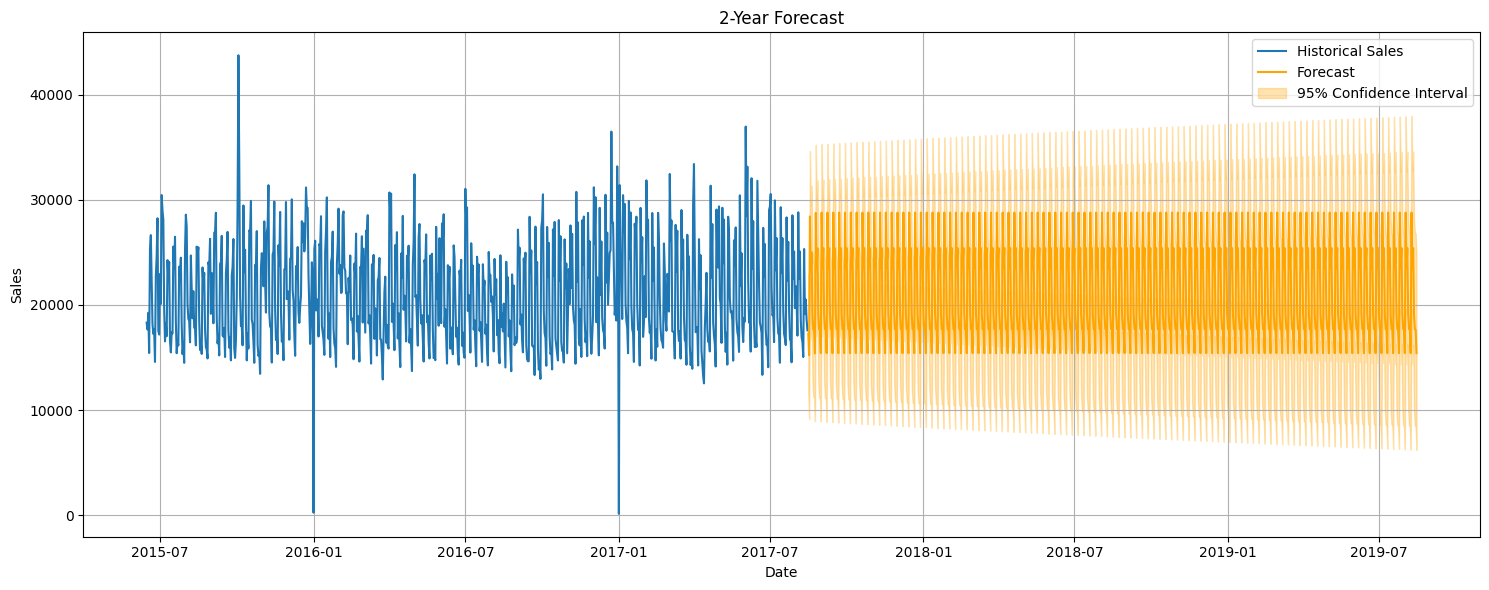

In [51]:
plt.figure(figsize=(15, 6))

# Plot past data
plt.plot(poultry_df.index, poultry_df['sales'], label='Historical Sales')

# Plot forecast
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='orange')

# Plot confidence intervals
plt.fill_between(forecast_index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='orange', alpha=0.3, label='95% Confidence Interval')

plt.title("2-Year Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


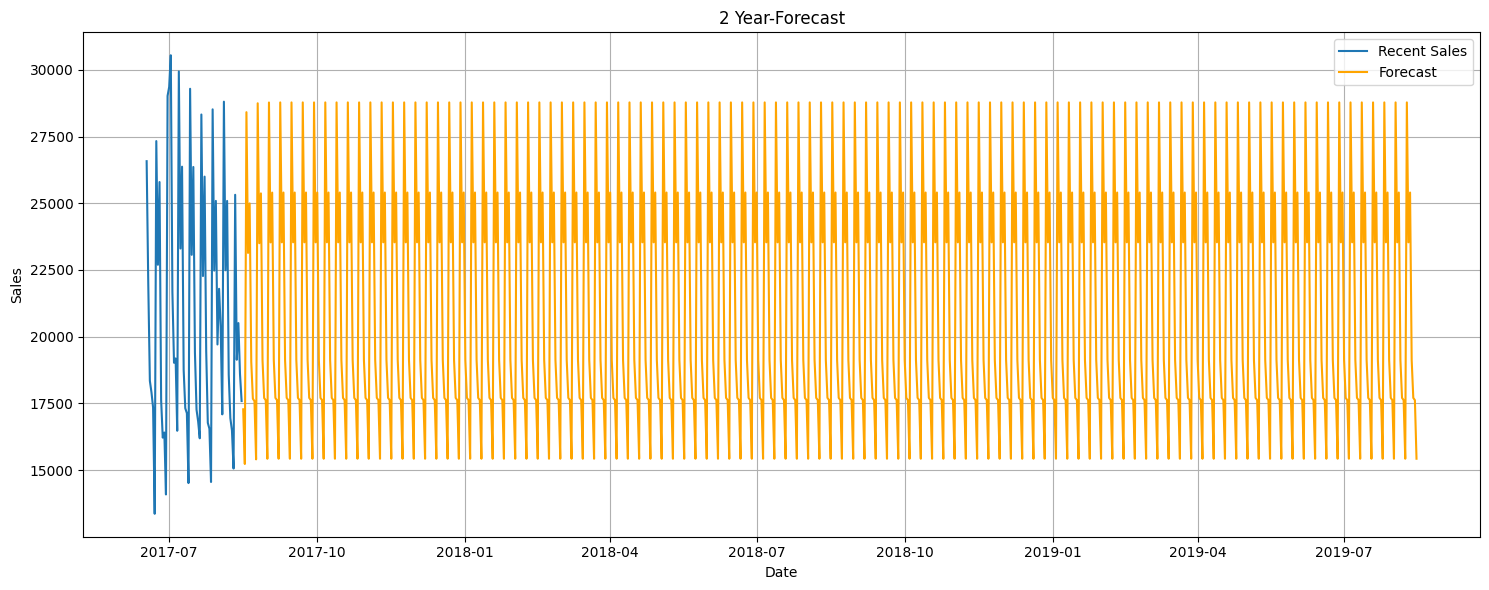

In [52]:
context_days = 60 

recent_history = poultry_df.iloc[-context_days:]

plt.figure(figsize=(15, 6))

# Historical data (just last 60 days)
plt.plot(recent_history.index, recent_history['sales'], label='Recent Sales')

# Forecast
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='orange')

plt.title("2 Year-Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
